## Loading in Modules for the Bias Analysis

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj

#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from matplotlib.path import Path

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob
import array

## Loading Functions Required for the Analysis

In [3]:
def getPolyCoords(row, geom, coord_type):
    """
    Returns the coordinates ('x|y') of edges/vertices of a Polygon/others
    Args:
    - row: the row object from a geodataframe; i.e.   df.loc[1]
    - geom: the name of "geometry" column, usually "geometry"
    - coord_type: 'x', or 'y'
    ...
    Valid geometrie types 'Polygon', 'Point', 'LineString', 'MultiLineString', 'MultiPolygon'
    """

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        # updated code, using .geoms
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

### Bias Analysis for a Shelf 

A function that takes in the temperature from both the models and the ERA5 data and produces a plot with a bias analysis, a dataframe with the stored data, and a dataframe sorted by bias. Should be used for an individual shelf. 

#### Inputs
- shelf_name: Any shelf name from the dataframes read in to the script
- type_of_analysis: The type of analysis is eithre 'yearly' or 'seasonal'

#### Outputs
- f2: bar plot of bias for each CMIP6 model and the mean of the models. This bias is calculated by subtracting the ERA5 temperatures from the model temperatures across the timescale. The bias for eachmodel is produced by taking the mean of that variation. The mean of the CMIP6 models is calculated by taking the mean of the temperature at each time step and then performing the variation as mentioned above. 
- df_sortted: the dataframe of the CMIP6 models and their overall bias assigned based off of the ERA5 data in a dataframe sortted based on bias from negative to positive bias. The smallest bias will be towards the middle of the dataframe. 
- df_sortted: the dataframe of the CMIP6 models and their overall bias assigned based off of the ERA5 data in a dataframe 

In [23]:
shelf = yearly_shelves['Abbot']
shelf_reanalysis = yearly_reanalysis['Abbot']
shelf_time = yearly_reanalysis['Abbot']['year'][0]
shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['1940-2022'])+1,len(shelf['1940-2022'][0])))

for i in range(len(shelf['1940-2022'])):
    shelf_cropped_temp_spatial_avg[i] = np.mean(shelf['Bias-Corrected Models'][i],axis=1)

model_names = list(shelf['Model Names'])

models_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
model_names.append('Model Mean')

print(model_names)
shelf_cropped_temp_spatial_avg[-1]= models_mean


variation = np.zeros((len(shelf_cropped_temp_spatial_avg),len(shelf_cropped_temp_spatial_avg[0])))
print(variation.shape)

print(shelf_reanalysis['year'][0].shape)
for i in range(len(shelf_cropped_temp_spatial_avg)):
    variation[i] = shelf_cropped_temp_spatial_avg[i] - shelf_reanalysis['temp spatial average'][0]
    print(model_names[i])


mean_bias = np.mean(variation,axis=1)

fig = plt.figure()

for i in range(len(shelf_cropped_temp_spatial_avg)):
    plt.plot(shelf_time,shelf_cropped_temp_spatial_avg[i])
    
print(mean_bias)


KeyError: '1940-2022'

In [4]:
def bias_analysis_shelf(shelf_name,type_of_analysis):

    %matplotlib inline
    if type_of_analysis == 'yearly':
        shelf = yearly_shelves[shelf_name]
        shelf_reanalysis = yearly_reanalysis[shelf_name]
        
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        data_for_indicies_of_array_to_fill = yearly_shelves[shelf_name]['year'][0]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))
        
        for i in range(len(shelf['year'])):
            data_for_indicies = yearly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
        
        model_names = list(shelf['Model'])
        
        model_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')
        
        
        shelf_cropped_temp_spatial_avg[-1]= model_mean
        
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)
        

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

        fig = plt.figure()
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(22, 10), tight_layout=False)
        #plt.tick_params(labelsize=20)
        plt.tight_layout()
        
        for i in range(len(shelf_cropped_temp)):
            ax1.plot(shelf_cropped[i],shelf_cropped_temp_spatial_avg[i],linewidth=1,label = '_nolegend_', color= 'lightgray')
        
        ax1.text(0.05, 0.9,'Shelf: {}'.format(shelf_name),fontsize = 20, ha='left', va='center', transform=ax1.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        ax1.plot(shelf_cropped[0],model_mean,label = 'Ensemble Mean', color= 'orange')
        ax1.plot(shelf_reanalysis['year'][0],shelf_reanalysis['temp spatial average'][0],label = 'ERA5', color= 'blue')
        ax1.set_xlabel("Time(Years)", fontsize = 20)
        ax1.set_ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 22)
        ax1.tick_params(labelsize=16)
        ax1.legend(loc = 'lower right',fontsize=20)
        
        bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax2.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=16)
        ax2.set_xlim(left=min(y)-1.5)
        ax2.set_xlim(right=max(y)+1.5)
        ax2.set_xlabel(r"Mean Annual Temperature Bias($\degree$ C)", fontsize = 22)
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(labelsize=16)
        ax2.yaxis.tick_right()
    
        
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_yearly/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_yearly_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file), bbox_inches='tight')
    
    
    else: 
        shelf = seasonal_shelves[shelf_name]
        shelf_reanalysis = seasonal_reanalysis[shelf_name]
        
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        data_for_indicies_of_array_to_fill = yearly_shelves[shelf_name]['year'][0]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['original latitude'][0]),len(shelf['original longitude'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

        for i in range(len(shelf['year'])):
            data_for_indicies = yearly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
            
        model_names = list(shelf['Model'])
        
        model_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')
        
        
        shelf_cropped_temp_spatial_avg[-1]= model_mean
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)
        

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

        fig = plt.figure()
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(22, 10), tight_layout=True)
        #plt.tick_params(labelsize=20)
        plt.tight_layout()
        
        for i in range(len(shelf_cropped_temp)):
            ax1.plot(shelf_cropped[i],shelf_cropped_temp_spatial_avg[i],linewidth=1,label = '_nolegend_', color= 'lightgray')
        
        ax1.text(0.05, 0.9,'Shelf: {}'.format(shelf_name),fontsize = 20, ha='left', va='center', transform=ax1.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        ax1.plot(shelf_cropped[0],model_mean,label = 'Ensemble Mean', color= 'orange')
        ax1.plot(shelf_reanalysis['year'][0],shelf_reanalysis['temp spatial average'][0],label = 'ERA5', color= 'blue')
        ax1.set_xlabel("Time(Years)", fontsize = 20)
        ax1.set_ylabel(r"Austral Summer Surface Temperature ($\degree$ C)", fontsize = 20)
        ax1.tick_params(labelsize=16)
        ax1.legend(loc = 'lower right',fontsize=20)
        
        bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax2.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
        ax2.set_xlim(left=min(y)-1.5)
        ax2.set_xlim(right=max(y)+1.5)
        ax2.set_xlabel(r"Mean Austral Summer Temperature Bias($\degree$ C)", fontsize = 20)
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(labelsize=16)
        ax2.yaxis.tick_right()
        
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_seasonal/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_seasonal_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file), bbox_inches='tight')
        
        #plt.close()

    return df, df_sortted

In [5]:
bias_analysis_shelf('Amery','yearly')

NameError: name 'yearly_shelves' is not defined

In [6]:
def iceshelf_dictionary(dictionary,type_of_analysis):

    for key in dictionary:    
        df_shelf, df_shelf_sortted = bias_analysis_shelf(key,type_of_analysis)
        if type_of_analysis == 'seasonal':
            bias_analysis_seasonal[key] = df_shelf
            print(key)
        elif type_of_analysis == 'yearly':
            bias_analysis_yearly[key] = df_shelf
            print(key)
            
    task = 'completed task'
                
    return task

In [7]:
def iceshelf_gridsize(dictionary,type_of_analysis):
    
    gridsize_shelves = {}
    
    for key in dictionary:    
        if type_of_analysis == 'seasonal':
            shelf_gridsize = seasonal_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
    
        elif type_of_analysis == 'yearly':
            shelf_gridsize = yearly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
                
    return gridsize_shelves

In [8]:
def shelf_weights(dictionary,type_of_analysis,keys):

    gridsize_shelves = iceshelf_gridsize(dictionary,type_of_analysis)

    gridsize_for_group = {}
    
    total_shelf_weights = {}
    
    for key in keys:
        gridsize_for_group[key] = gridsize_shelves[key]  
    
    for key in gridsize_for_group: 
        total_shelf_weights[key] = gridsize_for_group[key]/sum(gridsize_for_group.values())

    return total_shelf_weights


In [9]:
def grouping_bias_analysis(dictionary,weights,keys):
    
    applied_weights = {}
    
    for key in keys:
        weighted_bias = dictionary[key]['Mean Bias'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights

In [10]:
def creating_model_bias_dict_and_plot(dictionary1,dictionary2,dictionary3,shelf_name):   
    model_bias = list()
    names = list()
    
    shelf_sorted = dictionary2[key].sort_values(by='Model')

    temp = shelf_sorted['temp spatial average']
    time = shelf_sorted['year']
    model_names = shelf_sorted['Model']

    temp_reanalysis = dictionary3[key]['temp spatial average'][0]
    time_reanalysis = dictionary3[key]['year'][0]

    y1 = 1940
    y2 = 2099

    time_len = y2+1-y1

    shelf_cropped_time = np.zeros((len(temp),time_len))
    shelf_cropped_temp = np.zeros((len(temp),time_len))
    
    Model = yearly_shelves_shelf['Model']
    Time = yearly_shelves_shelf['year']

    for i in range(len(model_names)):

        data_for_indicies = np.array(time[i])

        index1 = np.where(data_for_indicies == y1)[0][0]
        index2 = np.where(data_for_indicies == y2)[0][0]+1# Added to correct the time to make the models range from 1940-2022
            #print(index2)
        shelf_cropped_time[i] = time[i][index1:index2]
        shelf_cropped_temp[i] = new_model[index1:index2]

    df = pd.DataFrame(list(zip(Model,Mean_Bias,Time,new_models,shelf_cropped_time,shelf_cropped_temp)),columns=['Model','Bias','Time','Model Corrected by Offset','Cropped Time','Cropped Model'])

    model_mean = np.mean(shelf_cropped_temp,axis = 0)

    for i in range(len(dictionary1[shelf_name])):
        values = np.zeros(len(dictionary1))
        model_name = bias_analysis_yearly[shelf_name]['Model Names'][i]
        names.append(model_name)

        k = 0
        for key in dictionary1:
            x = dictionary1[key]['Mean Bias'][i]
            values[k] = x
            weight = np.sum(values)
            k += 1
            
        weight = np.sum(values)
        model_bias.append(weight)

    df = pd.DataFrame(list(zip(names,model_bias)),columns=['Model Names','Weighted Mean Bias'])

    df_sortted = df.sort_values("Weighted Mean Bias",ascending=False)

    x = df_sortted['Model Names']
    y = df_sortted['Weighted Mean Bias']

    cmap = plt.cm.seismic
    norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

    fig, (ax1, ax2) = plt.subplots(figsize=(15,12))
    plt.tick_params(axis='both', which='major', labelsize=16)

    for i in range(len(shelf_cropped_temp)):
        plt.plot(shelf_cropped_time[i],shelf_cropped_temp[i],linewidth=1,label = '_nolegend_', color= 'lightgray')

    ax1.plot(shelf_cropped_time[0],model_mean,label = 'Ensemble Mean', color= 'orange')
    ax1.plot(time_reanalysis,temp_reanalysis,label = 'ERA5', color= 'blue')
    ax1.axvline(x = shelf_cropped_time[0][index_TT[1]])
    ax1.set_xlabel("Time(Years)", fontsize = 18)
    ax1.set_ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 14)
    plt.legend()
    
    bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
    ax2.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
    ax2.set_xlim(left=min(y)-1)
    ax2.set_xlabel(r"Mean Annual Temperature Bias($\degree$ C)", fontsize = 14)

    my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/' # Figures out the absolute path for you in case your working directory moves around.
    my_file = 'weighted_yearly_bias_All_Shelves.png'

    plt.savefig(os.path.join(my_path, my_file))
    
    return f2,df_sortted

In [11]:
def best_bias_per_shelf(dictionary):
    Model = list()
    Mean_Bias = list()
    keys = list()
    variation = list()

    for key in dictionary:

        #Storing Iceshelf Name
        keys.append(key)

        #Model with the lowest Bias
        bestbias = dictionary[key].iloc[(dictionary[key]['Mean Bias']-0).abs().argsort()[:1]]
        #index = bestbias.index.to_numpy()
        Model.append(bestbias['Model Names'].tolist())
        Mean_Bias.append(bestbias['Mean Bias'].tolist())

        #variation in the bias values
        max_bias = dictionary[key]['Mean Bias'].max()
        min_bias = dictionary[key]['Mean Bias'].min()
        variation.append(np.abs(max_bias-min_bias))

    df = pd.DataFrame(list(zip(keys,Model,Mean_Bias,variation)),columns=['Ice Shelf','Model','Bias','Bias Variation'])
    
    return df


In [7]:
yearly_shelves['Abbot'].keys()

Index(['file path', 'Model', 'gridsize', 'temp', 'year', 'month',
       'original latitude', 'original longitude', 'cropped temp',
       'cropped lat', 'cropped lon', 'temp spatial average'],
      dtype='object')

## Reading in Pre-Made Data Frames

In [12]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/monthly_shelves.pkl', 'rb') as f:
    monthly_shelves = pickle.load(f)

In [13]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/seasonal_shelves.pkl', 'rb') as f:
    seasonal_shelves = pickle.load(f)

In [14]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/yearly_shelves.pkl', 'rb') as f:
    yearly_shelves = pickle.load(f)

In [15]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_monthly.pkl', 'rb') as f:
    monthly_reanalysis = pickle.load(f)

In [16]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_seasonal.pkl', 'rb') as f:
    seasonal_reanalysis = pickle.load(f)

In [17]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_yearly.pkl', 'rb') as f:
    yearly_reanalysis = pickle.load(f)

In [18]:
fname = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/TT_IS.nc'
datain = Dataset(fname, 'r')

fname_1 = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/dT_IS.nc'
datain1 = Dataset(fname_1, 'r')

TT = datain.variables['thresholdT'][:]
TT_uncertainty = datain1.variables['dTT'][:]


Names = ['Nansen','Drygalski','Ross West','Filchner','Ross East','Vigrid','Ronne','Amery',
        'Publications','Baudouin','Tracy Tremenchus','Lazarev','Rennick','LarsenB','Quar','Riiser-Larsen'
        'Brunt Stancomb','Tucker','Lily','Borchgrevink','Ekstrom','Mariner','Fimbul','Nivl','LarsenD'
        'Bach','LarsenC','LarsenE','Cook','West','Cosgrove','Jelbart','Sulzberger','Conger Glenzer',
        'Ninnis','Mertz','Pine Island','Shackleton','George VI','Moscow University','Nickerson','Prince Harald'
        ,'Wilkins','Thwaites','Frostman-Lord-Shuman-Anandakri','Stange','Getz','Slava','Dotson','Swinburne',
        'Crosson','Abbot','Totten','Land','Venable','Holmes']

Thresholds = pd.DataFrame(list(zip(Names,TT,TT_uncertainty)),columns=['Model Names','Threshold Temps','Temp Uncertainty'])

In [19]:
bias_analysis_seasonal = {}
bias_analysis_yearly = {}

Abbot
Amery
Atka
Baudouin
Borchgrevink
Conger Glenzer
Cook
Cosgrove
Crosson
Dotson
Drygalski
Ekstrom
Filchner
George VI
Getz
Holmes
Jelbart
Land
LarsenB
LarsenC
LarsenD
Lazarev
Mariner
Mertz
Moscow University
Nansen
Nickerson
Nivl
pine island
Prince Harald
Quar
Rennick
Riiser-Larsen
Ronne
Ross East
Ross West
Shackleton
Stange
Sulzberger
Thwaites
Totten
Venable
Vigrid
West
Withrow


'completed task'

<Figure size 640x480 with 0 Axes>

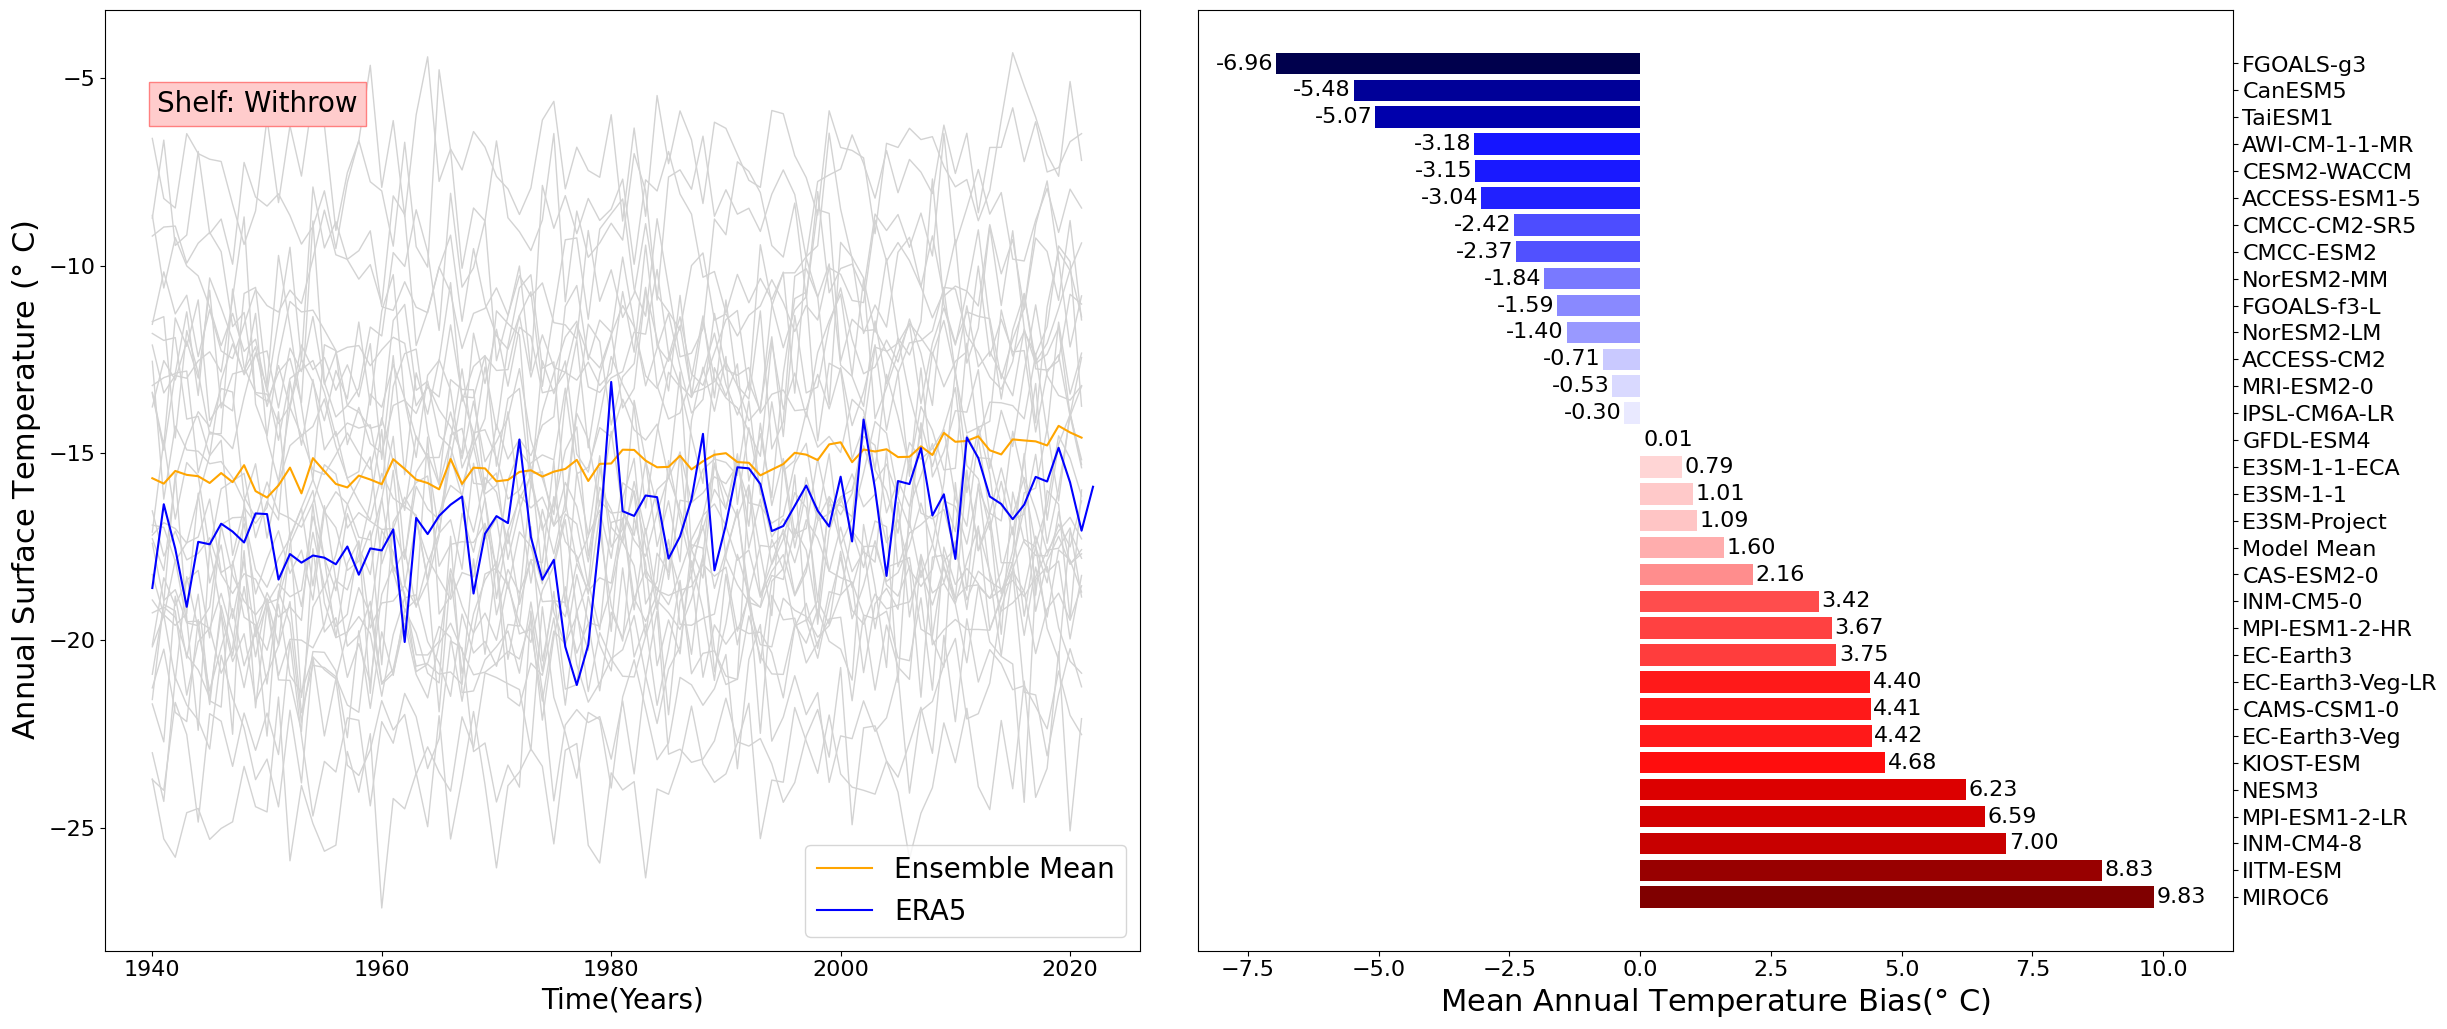

In [20]:
iceshelf_dictionary(yearly_shelves,'yearly')

Abbot
Amery
Atka
Baudouin
Borchgrevink
Conger Glenzer
Cook
Cosgrove
Crosson
Dotson
Drygalski
Ekstrom
Filchner
George VI
Getz
Holmes
Jelbart
Land
LarsenB
LarsenC
LarsenD
Lazarev
Mariner
Mertz
Moscow University
Nansen
Nickerson
Nivl
pine island
Prince Harald
Quar
Rennick
Riiser-Larsen
Ronne
Ross East
Ross West
Shackleton
Stange
Sulzberger
Thwaites
Totten
Venable
Vigrid
West
Withrow


'completed task'

<Figure size 640x480 with 0 Axes>

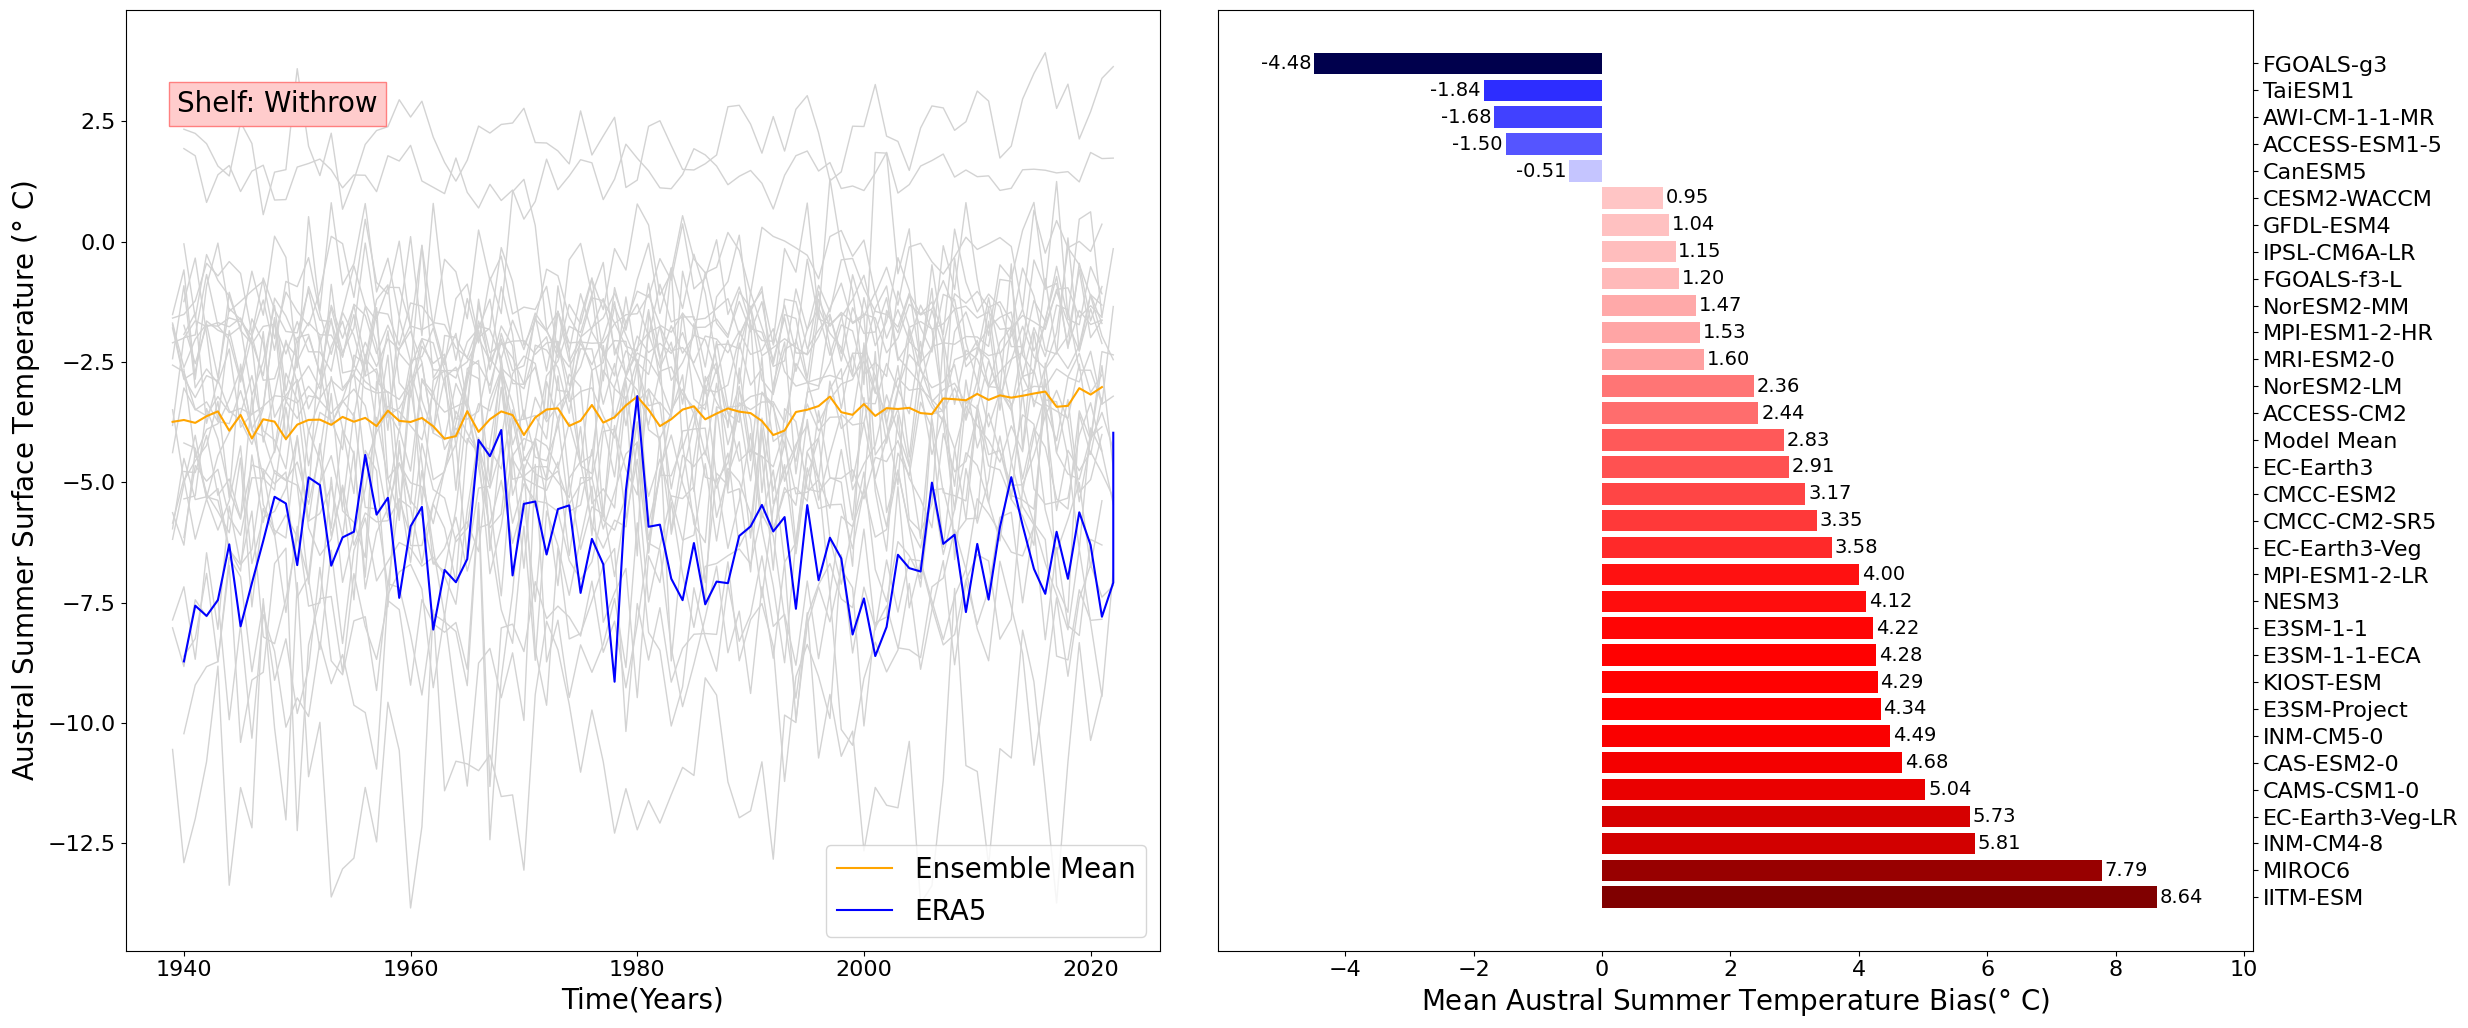

In [21]:
iceshelf_dictionary(seasonal_shelves,'seasonal')

In [19]:
with open('bias_analysis_yearly.pkl', 'wb') as f:
    pickle.dump(bias_analysis_yearly, f)

In [20]:
with open('bias_analysis_seasonal.pkl', 'wb') as f:
    pickle.dump(bias_analysis_seasonal, f)

In [22]:
bias_analysis_yearly['Abbot'].sort_values('Model Names')

Model Names  Mean Bias
20        ACCESS-CM2  -2.330131
18     ACCESS-ESM1-5  -1.068254
9      AWI-CM-1-1-MR  -1.904469
4        CAMS-CSM1-0   1.669094
1         CAS-ESM2-0   2.461220
28       CESM2-WACCM  -4.090516
11      CMCC-CM2-SR5  -3.071861
12         CMCC-ESM2  -2.727570
26           CanESM5  -3.542048
0           E3SM-1-1   1.104608
29      E3SM-1-1-ECA   0.818141
3       E3SM-Project   1.154275
14         EC-Earth3   2.788666
22     EC-Earth3-Veg   2.686422
23  EC-Earth3-Veg-LR   2.875686
8        FGOALS-f3-L  -1.254382
17         FGOALS-g3  -5.174135
21         GFDL-ESM4  -1.314581
15          IITM-ESM   6.184594
6          INM-CM4-8   2.961474
7          INM-CM5-0   2.426538
13      IPSL-CM6A-LR  -2.233295
2          KIOST-ESM   4.559068
27            MIROC6   6.511293
5      MPI-ESM1-2-HR  -0.115290
30     MPI-ESM1-2-LR   0.429804
25        MRI-ESM2-0  -2.031476
31        Model Mean   0.432721
24             NESM3   1.990793
19        NorESM2-LM  -1.510909
16        NorESM2-MM  -1.920616
10           TaiESM1  -5.321476

In [23]:
def bias_analysis_shelf_alphabet(dictionary):
    
    new_dictionary = {}
    
    for key in dictionary:
        new_dictionary[key] = dictionary[key].sort_values('Model Names')
    
    return new_dictionary

In [45]:
bias_analysis_shelf_alphabet_yearly = bias_analysis_shelf_alphabet(bias_analysis_yearly)
bias_analysis_shelf_alphabet_yearly

{'Abbot':          Model Names  Mean Bias
 20        ACCESS-CM2  -2.330131
 18     ACCESS-ESM1-5  -1.068254
 9      AWI-CM-1-1-MR  -1.904469
 4        CAMS-CSM1-0   1.669094
 1         CAS-ESM2-0   2.461220
 28       CESM2-WACCM  -4.090516
 11      CMCC-CM2-SR5  -3.071861
 12         CMCC-ESM2  -2.727570
 26           CanESM5  -3.542048
 0           E3SM-1-1   1.104608
 29      E3SM-1-1-ECA   0.818141
 3       E3SM-Project   1.154275
 14         EC-Earth3   2.788666
 22     EC-Earth3-Veg   2.686422
 23  EC-Earth3-Veg-LR   2.875686
 8        FGOALS-f3-L  -1.254382
 17         FGOALS-g3  -5.174135
 21         GFDL-ESM4  -1.314581
 15          IITM-ESM   6.184594
 6          INM-CM4-8   2.961474
 7          INM-CM5-0   2.426538
 13      IPSL-CM6A-LR  -2.233295
 2          KIOST-ESM   4.559068
 27            MIROC6   6.511293
 5      MPI-ESM1-2-HR  -0.115290
 30     MPI-ESM1-2-LR   0.429804
 25        MRI-ESM2-0  -2.031476
 31        Model Mean   0.432721
 24             NESM3   1.990793
 

In [51]:
bias_analysis_shelf_alphabet_yearly['Abbot']

Model Names  Mean Bias
20        ACCESS-CM2  -2.330131
18     ACCESS-ESM1-5  -1.068254
9      AWI-CM-1-1-MR  -1.904469
4        CAMS-CSM1-0   1.669094
1         CAS-ESM2-0   2.461220
28       CESM2-WACCM  -4.090516
11      CMCC-CM2-SR5  -3.071861
12         CMCC-ESM2  -2.727570
26           CanESM5  -3.542048
0           E3SM-1-1   1.104608
29      E3SM-1-1-ECA   0.818141
3       E3SM-Project   1.154275
14         EC-Earth3   2.788666
22     EC-Earth3-Veg   2.686422
23  EC-Earth3-Veg-LR   2.875686
8        FGOALS-f3-L  -1.254382
17         FGOALS-g3  -5.174135
21         GFDL-ESM4  -1.314581
15          IITM-ESM   6.184594
6          INM-CM4-8   2.961474
7          INM-CM5-0   2.426538
13      IPSL-CM6A-LR  -2.233295
2          KIOST-ESM   4.559068
27            MIROC6   6.511293
5      MPI-ESM1-2-HR  -0.115290
30     MPI-ESM1-2-LR   0.429804
25        MRI-ESM2-0  -2.031476
31        Model Mean   0.432721
24             NESM3   1.990793
19        NorESM2-LM  -1.510909
16        NorESM2-MM  -1.920616
10           TaiESM1  -5.321476

In [25]:
def shelf_alphabet(dictionary):
    
    new_dictionary = {}
    
    for key in dictionary:
        new_dictionary[key] = dictionary[key].sort_values('Model')
    
    return new_dictionary

In [64]:
yearly_shelves_abbot

file path             Model  \
21  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...        ACCESS-CM2   
19  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...     ACCESS-ESM1-5   
9   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...     AWI-CM-1-1-MR   
4   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...       CAMS-CSM1-0   
1   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...        CAS-ESM2-0   
29  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...       CESM2-WACCM   
12  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...      CMCC-CM2-SR5   
13  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         CMCC-ESM2   
27  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...           CanESM5   
0   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...          E3SM-1-1   
30  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...      E3SM-1-1-ECA   
3   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...      E3SM-Project   
15  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         EC-Earth3   
23  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...     EC-Earth3-Veg   
24  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...  EC-Earth3-Veg-LR   
8   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...       FGOALS-f3-L   
18  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         FGOALS-g3   
22  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         GFDL-ESM4   
16  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...          IITM-ESM   
6   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         INM-CM4-8   
7   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         INM-CM5-0   
14  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...      IPSL-CM6A-LR   
2   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...         KIOST-ESM   
28  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...            MIROC6   
5   /raid01/mafields/tas/MODELS_filtered/ssp585/ic...     MPI-ESM1-2-HR   
10  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...     MPI-ESM1-2-LR   
26  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...        MRI-ESM2-0   
25  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...             NESM3   
20  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...        NorESM2-LM   
17  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...        NorESM2-MM   
11  /raid01/mafields/tas/MODELS_filtered/ssp585/ic...           TaiESM1   

    gridsize                                               temp  \
21       285  [[[-9.942474, -10.345795, -10.749084, -11.1523...   
19       285  [[[-8.958313, -9.174347, -9.5383, -9.902283, -...   
9        285  [[[-11.258057, -11.486053, -11.947357, -12.408...   
4        285  [[[-9.682709, -9.79599, -9.909271, -10.0225525...   
1        285  [[[-8.438019, -8.466522, -8.494965, -8.51413, ...   
29       285  [[[-17.12207, -17.528198, -17.934326, -18.3404...   
12       285  [[[-10.835663, -10.956085, -11.076477, -11.196...   
13       285  [[[-10.915253, -11.103668, -11.292084, -11.480...   
27       285  [[[-15.849609, -15.916412, -15.983215, -16.049...   
0        285  [[[-10.630127, -10.647766, -10.665436, -10.683...   
30       285  [[[-8.815155, -8.832397, -8.84967, -8.866913, ...   
3        285  [[[-6.888397, -6.901947, -6.915497, -6.9290466...   
15       285  [[[-4.853821, -5.02771, -5.2016296, -5.375, -5...   
23       285  [[[-5.722687, -5.9593506, -6.195984, -6.432251...   
24       285  [[[-9.674347, -10.01947, -10.364624, -10.70974...   
8        285  [[[-11.504425, -11.854828, -12.100586, -12.346...   
18       285  [[[-13.916443, -14.098785, -14.281158, -14.463...   
22       285  [[[-12.906799, -13.078217, -13.23999, -13.4017...   
16       285  [[[-2.8789978, -2.963379, -3.0548706, -3.14639...   
6        285  [[[-4.8936157, -4.919525, -4.9454346, -4.97134...   
7        285  [[[-3.5680542, -3.5793152, -3.5905457, -3.6018...   
14       285  [[[-11.881592, -12.078461, -12.27536, -12.4722...   
2        285  [[[-4.6848145, -4.710602, -4.736389, -4.762176...   
28       285  [[[-3.25589, -3.33856

In [77]:
yearly_shelves_abbot = yearly_shelves['Abbot'].sort_values(by='Model')

yearly_shelves_abbot

new_models = list()

for i in range(len(yearly_shelves['Abbot']['Model'])):
    Time = yearly_shelves_abbot['year']
    Mean_Bias = bias_analysis_shelf_alphabet_yearly['Abbot']['Mean Bias']
    Model = yearly_shelves_abbot['Model']
    new_model = yearly_shelves_abbot['temp spatial average'][i] - Mean_Bias[i]
    new_models.append(new_model)

df = pd.DataFrame(list(zip(Model,Mean_Bias,Time,new_models)),columns=['Model','Bias','Time','Model Corrected by Offset'])

df

Model      Bias  \
0         ACCESS-CM2 -2.330131   
1      ACCESS-ESM1-5 -1.068254   
2      AWI-CM-1-1-MR -1.904469   
3        CAMS-CSM1-0  1.669094   
4         CAS-ESM2-0  2.461220   
5        CESM2-WACCM -4.090516   
6       CMCC-CM2-SR5 -3.071861   
7          CMCC-ESM2 -2.727570   
8            CanESM5 -3.542048   
9           E3SM-1-1  1.104608   
10      E3SM-1-1-ECA  0.818141   
11      E3SM-Project  1.154275   
12         EC-Earth3  2.788666   
13     EC-Earth3-Veg  2.686422   
14  EC-Earth3-Veg-LR  2.875686   
15       FGOALS-f3-L -1.254382   
16         FGOALS-g3 -5.174135   
17         GFDL-ESM4 -1.314581   
18          IITM-ESM  6.184594   
19         INM-CM4-8  2.961474   
20         INM-CM5-0  2.426538   
21      IPSL-CM6A-LR -2.233295   
22         KIOST-ESM  4.559068   
23            MIROC6  6.511293   
24     MPI-ESM1-2-HR -0.115290   
25     MPI-ESM1-2-LR  0.429804   
26        MRI-ESM2-0 -2.031476   
27             NESM3  0.432721   
28        NorESM2-LM  1.990793   
29        NorESM2-MM -1.510909   
30           TaiESM1 -1.920616   

                                                 Time  \
0   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
1   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
2   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
3   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
4   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
5   [1849, 1850, 1851, 1852, 1853, 1854, 1855, 185...   
6   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
7   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
8   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
9   [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
10  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
11  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
12  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
13  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
14  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
15  [1849, 1850, 1851, 1852, 1853, 1854, 1855, 185...   
16  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
17  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
18  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
19  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
20  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
21  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
22  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
23  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
24  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
25  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
26  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
27  [1850, 1851, 1852, 1853, 1854, 1855, 1856, 185...   
28  [1849, 1850, 1851, 1852, 1853, 1854, 1855, 185...   
29  [1849, 1850, 1851, 1852, 1853, 1854, 1855, 185...   
30  [1849, 1850, 1851, 1852, 1853, 1854, 1855, 185...   

                            Model Corrected by Offset  
0   [-14.715747, -14.420383, -13.319626, -15.66913...  
1   [-13.269274, -12.328749, -14.014989, -14.35753...  
2   [-11.508314, -14.318584, -13.6531315, -12.1460...  
3   [-10.663845, -10.878683, -13.249861, -13.11108...  
4   [-14.600025, -14.773928, -12.905635, -12.88698...  
5   [-12.742818, -14.033858, -14.992143, -14.20722...  
6   [-14.978626, -14.5805025, -15.1655245, -14.006...  
7   [-12.414501, -14.512972, -13.899607, -15.14009...  
8   [-14.710547, -13.022376, -11.126129, -13.45378...  
9   [-13.123489, -12.209211, -12.809928, -13.12402...  
10  [-10.750951, -13.613253, -13.730745, -14.03665...  
11  [-13.621027, -14.948748, -13.701382, -15.94017...  
12  [-10.2755785, -10.137854, -12.155989, -13.0355...  
13  [-11.742516, -12.183488, -12.340915, -12.20266...  
14  [-14.054117, -14.047461, -13.981958, -12.00752...  
15  [-11.802151, -16.332066, -13.069093, -14.87075...  
16  [-12.692342, -12.541136, -11.766965, -13.57377...  
17  [-16.436209, -14.475381, -12.92824, -11.940399...  
18  [-12.421568, -13.401869, -14.0092

In [56]:
onset_dict = {}

In [59]:
    
for key in yearly_shelves:
    print(key)
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx

    yearly_shelves_shelf = yearly_shelves[key].sort_values(by='Model')

    #yearly_shelves_shelf

    temp = yearly_shelves_shelf['temp spatial average']
    time = yearly_shelves_shelf['year']
    model_names = yearly_shelves_shelf['Model']

    temp_reanalysis = yearly_reanalysis[key]['temp spatial average'][0]
    time_reanalysis = yearly_reanalysis[key]['year'][0]

    new_models = list()

    y1 = 1940
    y2 = 2099

    time_len = y2+1-y1

    shelf_cropped_time = np.zeros((len(temp),time_len))
    shelf_cropped_temp = np.zeros((len(temp),time_len))
    
    Model = yearly_shelves_shelf['Model']
    Time = yearly_shelves_shelf['year']

    for i in range(len(model_names)):
        Mean_Bias = bias_analysis_shelf_alphabet_yearly[key]['Mean Bias']
        new_model = yearly_shelves_shelf['temp spatial average'][i] - Mean_Bias[i]
        new_models.append(new_model)

        data_for_indicies = np.array(time[i])

        index1 = np.where(data_for_indicies == y1)[0][0]
        index2 = np.where(data_for_indicies == y2)[0][0]+1# Added to correct the time to make the models range from 1940-2022
            #print(index2)
        shelf_cropped_time[i] = time[i][index1:index2]
        shelf_cropped_temp[i] = new_model[index1:index2]

    df = pd.DataFrame(list(zip(Model,Mean_Bias,Time,new_models,shelf_cropped_time,shelf_cropped_temp)),columns=['Model','Bias','Time','Model Corrected by Offset','Cropped Time','Cropped Model'])

    model_mean = np.mean(shelf_cropped_temp,axis = 0)

    #print(model_mean)

    #fig, ax = plt.subplots()
    #f1 = plt.figure(1,figsize=(15,12))

    f1, ax = plt.subplots(figsize=(15,12))

    for i in range(len(df['Model'])):
        plt.plot(Time[i],new_models[i],linewidth=1,label = '_nolegend_', color= 'lightgray')
    
    
    shelf_name_key = list()
    onset_time = list()
    onset_temp = list()
    onset_temp_uncertainty = list()
    model_mean_temp = list()
    

    if np.where(Thresholds['Model Names'] == key )[0].size > 0:
        
        shelf_name_key.append(key) 
        where = np.where(Thresholds['Model Names'] == key )[0][0]
        
        shelf_threshold = Thresholds['Threshold Temps'][where]
        shelf_threshold_uncertainty = Thresholds['Temp Uncertainty'][where]

        shelf_threshold_lower = shelf_threshold-shelf_threshold_uncertainty
        shelf_threshold_upper = shelf_threshold+shelf_threshold_uncertainty

        index_TT = find_nearest(model_mean,shelf_threshold)
        index_TT_lowerbound = find_nearest(model_mean,shelf_threshold_lower)
        index_TT_upperbound = find_nearest(model_mean,shelf_threshold_upper)

        print(shelf_threshold,shelf_threshold_uncertainty,shelf_cropped_time[0][index_TT[1]],model_mean[index_TT[1]])
        onset_time.append(shelf_cropped_time[0][index_TT[1]])
        onset_temp.append(shelf_threshold)
        onset_temp_uncertainty.append(shelf_threshold_uncertainty)
        model_mean_temp.append(model_mean[index_TT[1]])
        print(shelf_threshold_lower,shelf_cropped_time[0][index_TT_lowerbound[1]],model_mean[index_TT_lowerbound[1]])
        print(shelf_threshold_upper,shelf_cropped_time[0][index_TT_upperbound[1]],model_mean[index_TT_upperbound[1]])

        std = 0.1
    
        if shelf_threshold-std <= model_mean[index_TT[1]] <= shelf_threshold+std: 
            plt.axvline(x = shelf_cropped_time[0][index_TT[1]],color='k',linestyle='--')
            plt.text(0.1, 0.9,'Shelf: {}'.format(key)+ '\n' + r'Threshold: {:.2f}$\degree$C in {} '.format(model_mean[index_TT[1]],int(shelf_cropped_time[0][index_TT[1]])),fontsize = 16, ha='left', va='center', transform=ax.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
            #plt.text(0.1, 0.87,r'Threshold: {:.2f}$\degree$C in {} '.format(model_mean[index_TT[1]],int(shelf_cropped_time[0][index_TT[1]])) ,rotation=0,fontsize = 16,ha='left', va='top', transform=ax.transAxes)
            #plt.text(0.1, 0.9,'Shelf: {}'.format(key),fontsize = 16, ha='center', va='center', transform=ax.transAxes)
            y_TL = shelf_cropped_time[0][index_TT_lowerbound[1]]
            y_TU = shelf_cropped_time[0][index_TT_upperbound[1]]
            plt.errorbar(((y_TL+y_TU)/2),min(temp_reanalysis)-3,xerr=y_TU-((y_TL+y_TU)/2),capsize=20,color = 'red')
        else: 
            plt.text(0.1, 0.9,'Shelf: {}'.format(key)+ '\n' + r'Threshold: {:.2f}$\degree$C not reached '.format(shelf_threshold),fontsize = 16, ha='left', va='center', transform=ax.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
    
        plt.plot(shelf_cropped_time[0],model_mean,label = 'Ensemble Mean', color= 'orange')
        #plt.text(min(time_reanalysis),max(temp_reanalysis)+10,r'Shelf:{}'.format(key) ,rotation=0,fontsize = 16)
        #plt.text(0.1, 0.9,'Shelf: {}'.format(key),fontsize = 16, ha='left', va='center', transform=ax.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        plt.plot(time_reanalysis,temp_reanalysis,label = 'ERA5', color= 'blue')    
        plt.xlabel("Time(Years)", fontsize = 18)
        plt.ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlim(1940,2100)
        #f1.tight_layout()
        plt.close()
        #my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/' # Figures out the absolute path for you in case your working directory moves around.
        #my_file = r'threshold_plot_{}.png'.format(key)

        #plt.savefig(os.path.join(my_path, my_file))
    else:
        print('skip')
        plt.close()
        
    onset_df =  pd.DataFrame(list(zip(shelf_name_key,onset_time,onset_temp,onset_temp_uncertainty,model_mean_temp)),columns=['Shelf','Onset Time','Onset Temp','Onset Temp Uncertainty','Model Mean Temp'])  
    onset_dict[key] = onset_df
    

Abbot
-4.99892659504156 0.6118635665732313 2099.0 -7.042216185600527
-5.6107901616147915 2099.0 -7.042216185600527
-4.3870630284683285 2099.0 -7.042216185600527
Amery
-20.228552878056185 1.1681716328687997 1989.0 -20.238890617124497
-21.396724510924983 1946.0 -20.645573154572517
-19.060381245187386 2027.0 -19.0687862519295
Atka
skip
Baudouin
-12.936223664367008 0.4953511151152371 2049.0 -12.939758793000252
-13.431574779482245 2044.0 -13.437332737830378
-12.44087254925177 2056.0 -12.427566866720877
Borchgrevink
-12.406679716139621 0.5401393858369833 2056.0 -12.371114392434396
-12.946819101976605 2049.0 -12.924160095953173
-11.866540330302637 2069.0 -11.873143995961835
Conger Glenzer
-8.087216644102684 0.6165625042624798 2097.0 -8.069090458654589
-8.703779148365165 2088.0 -8.771690245597593
-7.470654139840204 2099.0 -7.950229152556388
Cook
-12.603293308161486 0.2143043034360361 2071.0 -12.603429271328833
-12.817597611597522 2066.0 -12.781106518160913
-12.38898900472545 2072.0 -12.3136173

In [168]:
np.where(Thresholds['Model Names'] == 'Atka' )[0]

array([], dtype=int64)

In [ ]:
temp = bias_corrected_yearly['Abbot']['Full Bias-Corrected Model'][0]
#print(temp)
time = bias_corrected_yearly['Abbot']['Total Time'][0]
print(time)
model_names = bias_corrected_yearly['Abbot']['Model Names']

test = temp

print(len(test))

y1 = 1940
y2 = 2099

shelf_cropped_time = np.zeros((len(test),160))
shelf_cropped_temp = np.zeros((len(test),160))

for i in range(len(test)):
    
    data_for_indicies = np.array(time[i])

    index1 = np.where(data_for_indicies == y1)[0][0]
    #print(index1)
    index2 = np.where(data_for_indicies == y2)[0][0]+1# Added to correct the time to make the models range from 1940-2022
    #print(index2)
    shelf_cropped_time[i] = time[i][index1:index2]
    shelf_cropped_temp[i] = temp[i][index1:index2]
    
shelf_cropped_temp.shape

model_mean = np.mean(shelf_cropped_temp,axis = 0)

#model_mean = np.mean(np.array(temp),axis=0

temp_reanalysis = reanalysis_yearly['Abbot']['temp spatial average'][0]
time_reanalysis = reanalysis_yearly['Abbot']['year'][0]

plt.figure(figsize=(15,12))

#for i in range(len(shelf_cropped_temp)):
plt.plot(time[0],temp[0],linewidth=1,label = '_nolegend_', color= 'lightgray')
    #plt.plot(time[i],temp[i],linewidth=1,label = model_names[0], color= 'lightgray')
    

#plt.plot(NorESM['Total Time'][0],NorESM['Full Bias-Corrected Model'][0],label = 'NorESM2-MM corrected', color = 'red')

plt.plot(shelf_cropped_time[0],model_mean,label = 'Ensemble Mean', color= 'orange')
plt.plot(time_reanalysis,temp_reanalysis,label = 'ERA5', color= 'blue')
plt.xlabel("Time(Years)", fontsize = 18)
plt.ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1940,2100)
plt.legend()


In [1]:
fname = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/TT_IS.nc'
datain = Dataset(fname, 'r')

fname_1 = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/dT_IS.nc'
datain1 = Dataset(fname_1, 'r')

TT = datain.variables['thresholdT'][:]
TT_uncertainty = datain1.variables['dTT'][:]


Names = ['Nansen','Drygalski','Ross West','Filchner','Ross East','Vigrid','Ronne','Amery',
        'Publications','Baudouin','Tracy Tremenchus','Lazarev','Rennick','LarsenB','Quar','Riiser-Larsen'
        'Brunt Stancomb','Tucker','Lily','Borchgrevink','Ekstrom','Mariner','Fimbul','Nivl','LarsenD'
        'Bach','LarsenC','LarsenE','Cook','West','Cosgrove','Jelbart','Sulzberger','Conger Glenzer',
        'Ninnis','Mertz','Pine Island','Shackleton','George VI','Moscow University','Nickerson','Prince Harald'
        ,'Wilkins','Thwaites','Frostman-Lord-Shuman-Anandakri','Stange','Getz','Slava','Dotson','Swinburne',
        'Crosson','Abbot','Totten','Land','Venable','Holmes']

Thresholds = pd.DataFrame(list(zip(Names,TT,TT_uncertainty)),columns=['Model Names','Threshold Temps','Temp Uncertainty'])


NameError: name 'Dataset' is not defined

### Creating Weights for Study Regions

1) Ross Ice Shelf: includes Ross East and Ross West 
2) Ronne-Filcner: includes Ronne and Filchner 
3) Larsen: includes Larsen B,C, and D
4) Amundsen Sea Embayment (ASE): includes 'Getz','Dotson','Crosson','Thwaites','pine island','Cosgrove', 'Abbot', 'Venable'

In [46]:
bias_analysis_shelf_alphabet_seasonal = bias_analysis_shelf_alphabet(bias_analysis_seasonal)
bias_analysis_shelf_alphabet_seasonal

{'Abbot':          Model Names  Mean Bias
 20        ACCESS-CM2   0.359464
 18     ACCESS-ESM1-5  -0.423530
 9      AWI-CM-1-1-MR  -1.313157
 4        CAMS-CSM1-0   3.870945
 1         CAS-ESM2-0   4.780314
 28       CESM2-WACCM   0.572635
 11      CMCC-CM2-SR5   1.719546
 12         CMCC-ESM2   1.791622
 26           CanESM5  -1.164244
 0           E3SM-1-1   3.492754
 29      E3SM-1-1-ECA   3.329053
 3       E3SM-Project   3.425296
 14         EC-Earth3   4.618488
 22     EC-Earth3-Veg   4.895111
 23  EC-Earth3-Veg-LR   4.447593
 8        FGOALS-f3-L   1.215799
 17         FGOALS-g3  -2.862908
 21         GFDL-ESM4   0.120922
 15          IITM-ESM   6.979115
 6          INM-CM4-8   3.931937
 7          INM-CM5-0   3.429746
 13      IPSL-CM6A-LR   0.209606
 2          KIOST-ESM   2.545258
 27            MIROC6   5.764711
 5      MPI-ESM1-2-HR  -0.173157
 30     MPI-ESM1-2-LR   0.071154
 25        MRI-ESM2-0   0.132430
 31        Model Mean   1.934895
 24             NESM3   0.839421
 

In [27]:
#Weights for Analysis of the Ross Iceshelf

keys = list(('Ross East','Ross West'))

weights_Ross = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ross)

{'Ross East': 0.37747554282987356, 'Ross West': 0.6225244571701265}


In [28]:
#Weights for Analysis of the Ronne-Filchner

keys = list(('Ronne','Filchner'))

weights_Ronne_Filchner = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ronne_Filchner)

{'Ronne': 0.7420069642291864, 'Filchner': 0.25799303577081356}


In [29]:
#Weights for Analysis of the Larsen Iceshelf

keys = list(('LarsenB','LarsenC','LarsenD'))

weights_Larsen = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Larsen)

{'LarsenB': 0.023076923076923078, 'LarsenC': 0.6038461538461538, 'LarsenD': 0.3730769230769231}


In [30]:
#Weights for Analysis of Amundsen Sea Embayment

keys = list(('Dotson','Crosson','Thwaites','pine island'))

weights_ASE = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_ASE)

{'Dotson': 0.28846153846153844, 'Crosson': 0.14423076923076922, 'Thwaites': 0.2403846153846154, 'pine island': 0.3269230769230769}


In [47]:
##Weights for All Shelves

gridsize_shelves = iceshelf_gridsize(yearly_shelves,'yearly')

total_shelf_weights = {}

for key in gridsize_shelves: 
    total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())

print(total_shelf_weights)

{'Abbot': 0.015256588072122053, 'Amery': 0.025285394217433053, 'Atka': 0.0009602048436999893, 'Baudouin': 0.013229488957644298, 'Borchgrevink': 0.008961911874533234, 'Conger Glenzer': 0.0004267577083111064, 'Cook': 0.001280273124933319, 'Cosgrove': 0.0011735836978555424, 'Crosson': 0.0016003414061666488, 'Dotson': 0.0032006828123332977, 'Drygalski': 0.0008535154166222128, 'Ekstrom': 0.002560546249866638, 'Filchner': 0.08695188306838793, 'George VI': 0.01066894270777766, 'Getz': 0.01749706604075536, 'Holmes': 0.0008535154166222128, 'Jelbart': 0.004480955937266617, 'Land': 0.00032006828123332977, 'LarsenB': 0.0006401365624666595, 'LarsenC': 0.016750240051210924, 'LarsenD': 0.010348874426544329, 'Lazarev': 0.0037341299477221808, 'Mariner': 0.0014936519790888724, 'Mertz': 0.002027099114477755, 'Moscow University': 0.0016003414061666488, 'Nansen': 0.0009602048436999893, 'Nickerson': 0.004160887656033287, 'Nivl': 0.002880614531099968, 'pine island': 0.0036274405206444043, 'Prince Harald': 0.

In [35]:
ross_applied_weights

{'Ross East':          Model Names  Mean Bias
 20        ACCESS-CM2   0.321540
 18     ACCESS-ESM1-5  -1.038831
 9      AWI-CM-1-1-MR  -1.051736
 4        CAMS-CSM1-0   3.000487
 1         CAS-ESM2-0   2.965612
 28       CESM2-WACCM   0.578142
 11      CMCC-CM2-SR5   1.997582
 12         CMCC-ESM2   1.973206
 26           CanESM5   0.251725
 0           E3SM-1-1   1.924376
 29      E3SM-1-1-ECA   1.971453
 3       E3SM-Project   2.002909
 14         EC-Earth3   0.575446
 22     EC-Earth3-Veg   0.635714
 23  EC-Earth3-Veg-LR   0.155113
 8        FGOALS-f3-L   0.885883
 17         FGOALS-g3  -1.698903
 21         GFDL-ESM4  -0.540763
 15          IITM-ESM   2.880757
 6          INM-CM4-8   1.085903
 7          INM-CM5-0   1.028554
 13      IPSL-CM6A-LR   0.010471
 2          KIOST-ESM   1.849590
 27            MIROC6   2.839206
 5      MPI-ESM1-2-HR  -0.675493
 30     MPI-ESM1-2-LR  -0.556635
 25        MRI-ESM2-0   0.824504
 31        Model Mean   0.882675
 24             NESM3  -0.2947

### Seasonal Bias Analysis

In [42]:
def creating_model_bias_dict_and_plot(dictionary1,keys,shelf_name):   
    model_bias = list()
    names = list()
    
    shelf_sorted = dictionary1

    for i in range(len(dictionary1[shelf_name])):
        values = np.zeros(len(dictionary1))
        model_name = dictionary1[shelf_name]['Model Names'][i]
        names.append(model_name)

        k = 0
        for key in dictionary1:
            x = shelf_sorted[key]['Mean Bias'][i]
            values[k] = x
            k += 1
            
        weight = np.sum(values)
        model_bias.append(weight)

    df = pd.DataFrame(list(zip(names,model_bias)),columns=['Model Names','Weighted Mean Bias'])

    df_sortted = df.sort_values("Weighted Mean Bias",ascending=False)

    x = df_sortted['Model Names']
    y = df_sortted['Weighted Mean Bias']

    cmap = plt.cm.seismic
    norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

    fig, (ax2) = plt.subplots(figsize=(15,12))
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
    ax2.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
    ax2.set_xlim(left=min(y)-1)
    ax2.set_xlabel(r"Mean Annual Temperature Bias($\degree$ C)", fontsize = 14)

    my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/' # Figures out the absolute path for you in case your working directory moves around.
    my_file = 'weighted_yearly_bias_All_Shelves.png'

    plt.savefig(os.path.join(my_path, my_file),bbox_inches='tight')
    
    return f2,df_sortted

{'Ross East':          Model Names  Mean Bias
20        ACCESS-CM2   0.321540
18     ACCESS-ESM1-5  -1.038831
9      AWI-CM-1-1-MR  -1.051736
4        CAMS-CSM1-0   3.000487
1         CAS-ESM2-0   2.965612
28       CESM2-WACCM   0.578142
11      CMCC-CM2-SR5   1.997582
12         CMCC-ESM2   1.973206
26           CanESM5   0.251725
0           E3SM-1-1   1.924376
29      E3SM-1-1-ECA   1.971453
3       E3SM-Project   2.002909
14         EC-Earth3   0.575446
22     EC-Earth3-Veg   0.635714
23  EC-Earth3-Veg-LR   0.155113
8        FGOALS-f3-L   0.885883
17         FGOALS-g3  -1.698903
21         GFDL-ESM4  -0.540763
15          IITM-ESM   2.880757
6          INM-CM4-8   1.085903
7          INM-CM5-0   1.028554
13      IPSL-CM6A-LR   0.010471
2          KIOST-ESM   1.849590
27            MIROC6   2.839206
5      MPI-ESM1-2-HR  -0.675493
30     MPI-ESM1-2-LR  -0.556635
25        MRI-ESM2-0   0.824504
31        Model Mean   0.882675
24             NESM3  -0.294759
19        NorESM2-LM   0.4

NameError: name 'f2' is not defined

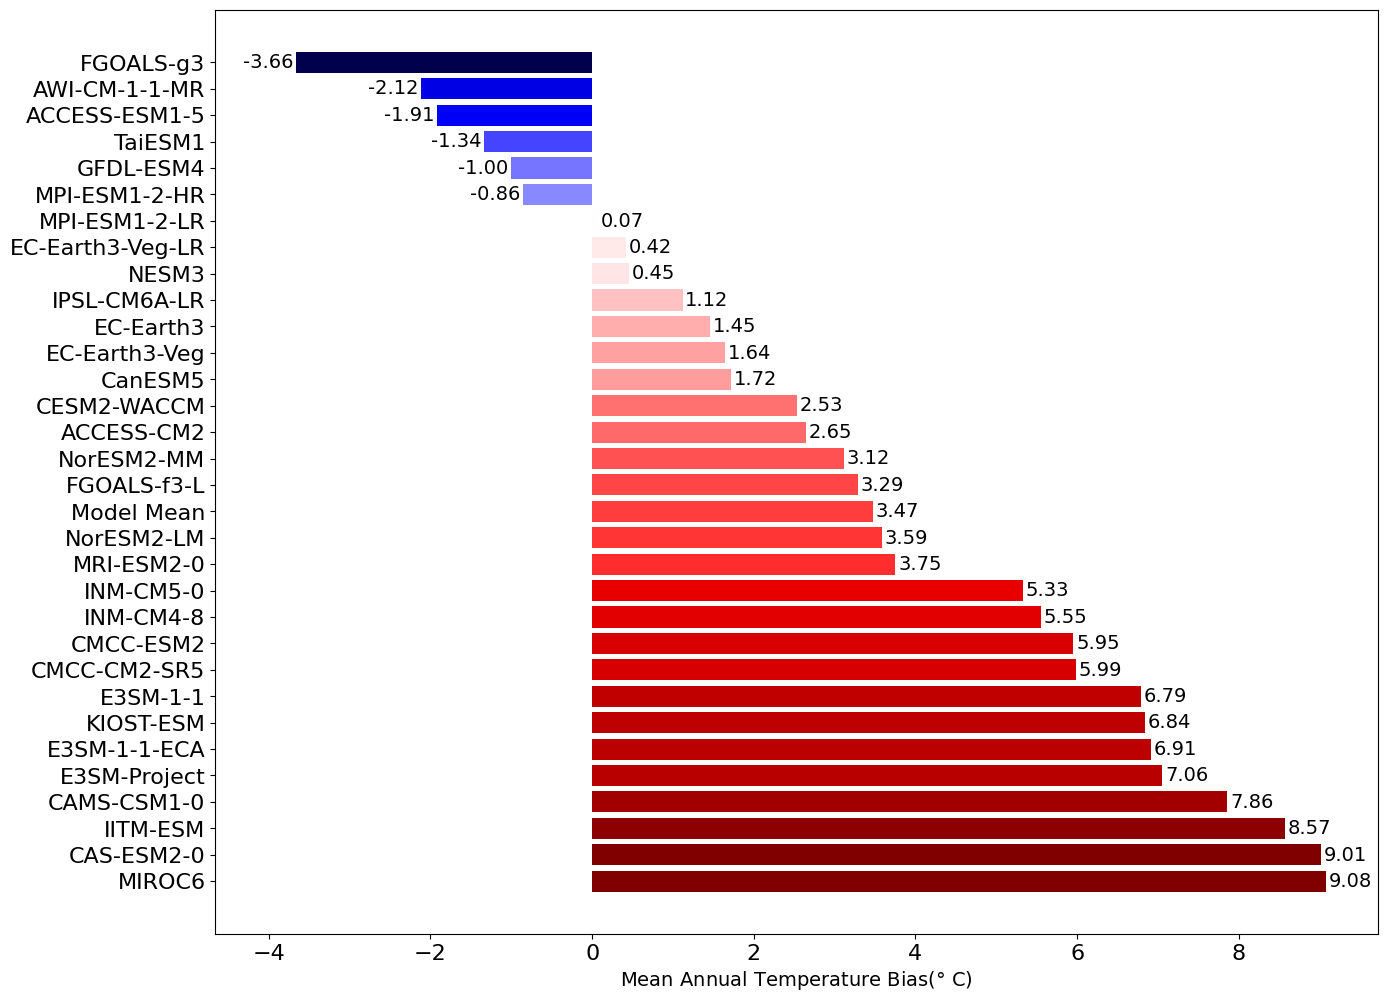

In [43]:
keys = list(('Ross East','Ross West'))

ross_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,weights_Ross,keys)

ross_yearly_fig, weights_ross_yearly_sortted = creating_model_bias_dict_and_plot(ross_applied_weights,keys,'Ross East')

(         Model Names  Mean Bias
 0           E3SM-1-1  -2.073267
 1         CAS-ESM2-0   6.139711
 2          KIOST-ESM   1.936641
 3       E3SM-Project  -1.985334
 4        CAMS-CSM1-0   7.009019
 5      MPI-ESM1-2-HR   3.765272
 6          INM-CM4-8  -5.896535
 7          INM-CM5-0  -6.108723
 8        FGOALS-f3-L   1.445924
 9      AWI-CM-1-1-MR  -1.866038
 10           TaiESM1  -5.650776
 11      CMCC-CM2-SR5  -1.658620
 12         CMCC-ESM2  -1.812731
 13      IPSL-CM6A-LR  -3.189026
 14         EC-Earth3   3.793064
 15          IITM-ESM   6.909706
 16        NorESM2-MM  -0.524101
 17         FGOALS-g3  -4.448660
 18     ACCESS-ESM1-5  -2.732842
 19        NorESM2-LM  -4.869173
 20        ACCESS-CM2  -3.160612
 21         GFDL-ESM4  -0.450314
 22     EC-Earth3-Veg   4.022240
 23  EC-Earth3-Veg-LR   2.656917
 24             NESM3   1.303803
 25        MRI-ESM2-0  -0.825884
 26           CanESM5  -3.807514
 27            MIROC6   3.440411
 28       CESM2-WACCM  -3.250117
 29      E

<Figure size 640x480 with 0 Axes>

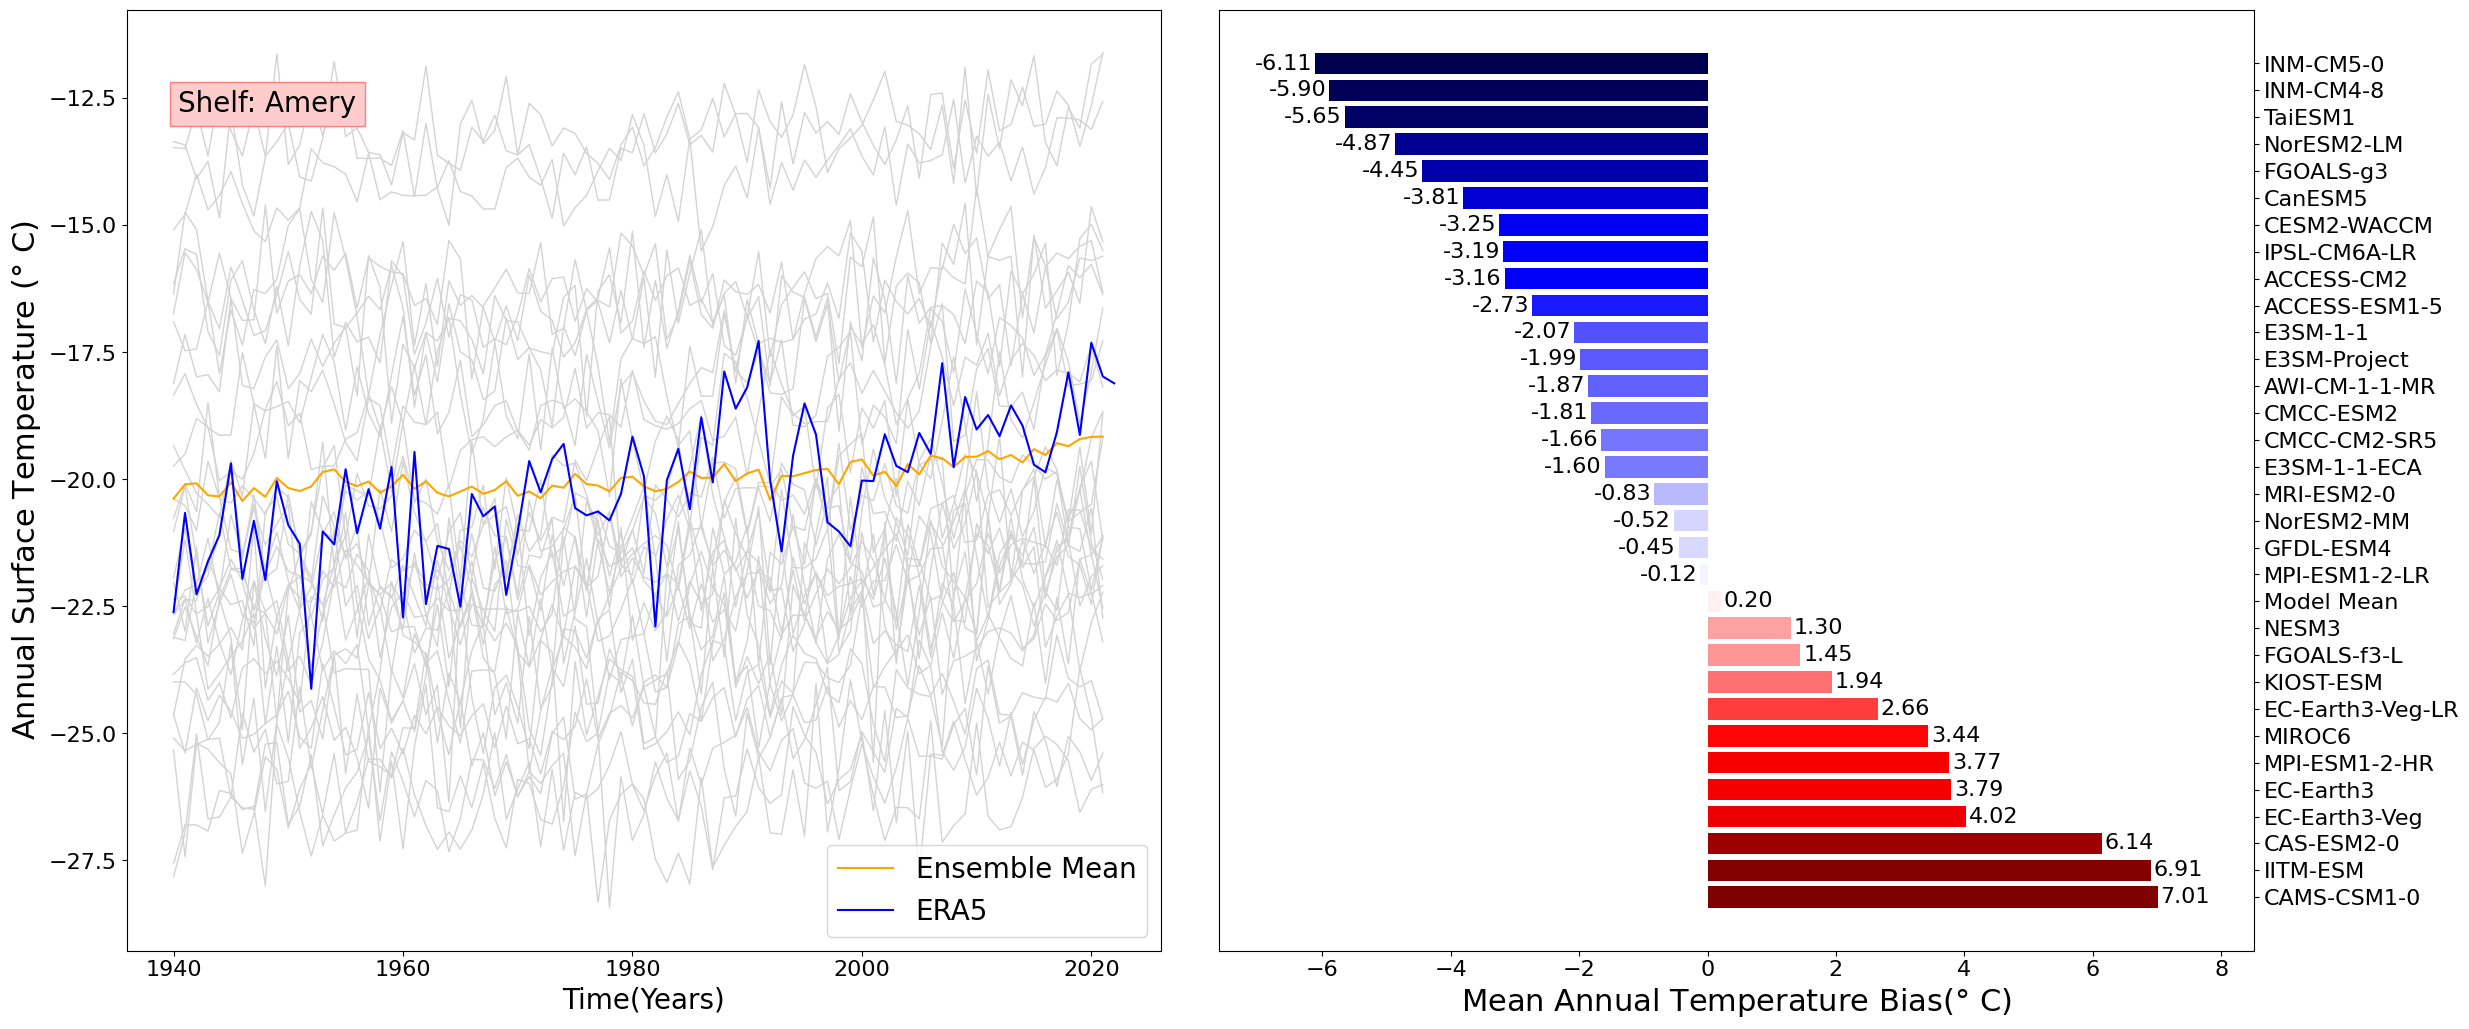

In [33]:
bias_analysis_shelf('Amery','yearly')

{'Ronne':          Model Names  Mean Bias
20        ACCESS-CM2   2.967865
18     ACCESS-ESM1-5  -1.303972
9      AWI-CM-1-1-MR  -1.066969
4        CAMS-CSM1-0   6.740930
1         CAS-ESM2-0   7.302055
28       CESM2-WACCM   2.394713
11      CMCC-CM2-SR5   5.105356
12         CMCC-ESM2   5.068194
26           CanESM5   0.967267
0           E3SM-1-1   5.896418
29      E3SM-1-1-ECA   5.994738
3       E3SM-Project   5.813646
14         EC-Earth3   1.497360
22     EC-Earth3-Veg   1.343353
23  EC-Earth3-Veg-LR   0.848468
8        FGOALS-f3-L   2.924373
17         FGOALS-g3  -1.195695
21         GFDL-ESM4  -1.662745
15          IITM-ESM   7.366765
6          INM-CM4-8   1.085525
7          INM-CM5-0   1.071148
13      IPSL-CM6A-LR   0.106803
2          KIOST-ESM   3.312382
27            MIROC6   7.763860
5      MPI-ESM1-2-HR  -0.725613
30     MPI-ESM1-2-LR  -0.313553
25        MRI-ESM2-0   3.079227
31        Model Mean   2.719749
24             NESM3   0.622920
19        NorESM2-LM   2.92687

NameError: name 'f2' is not defined

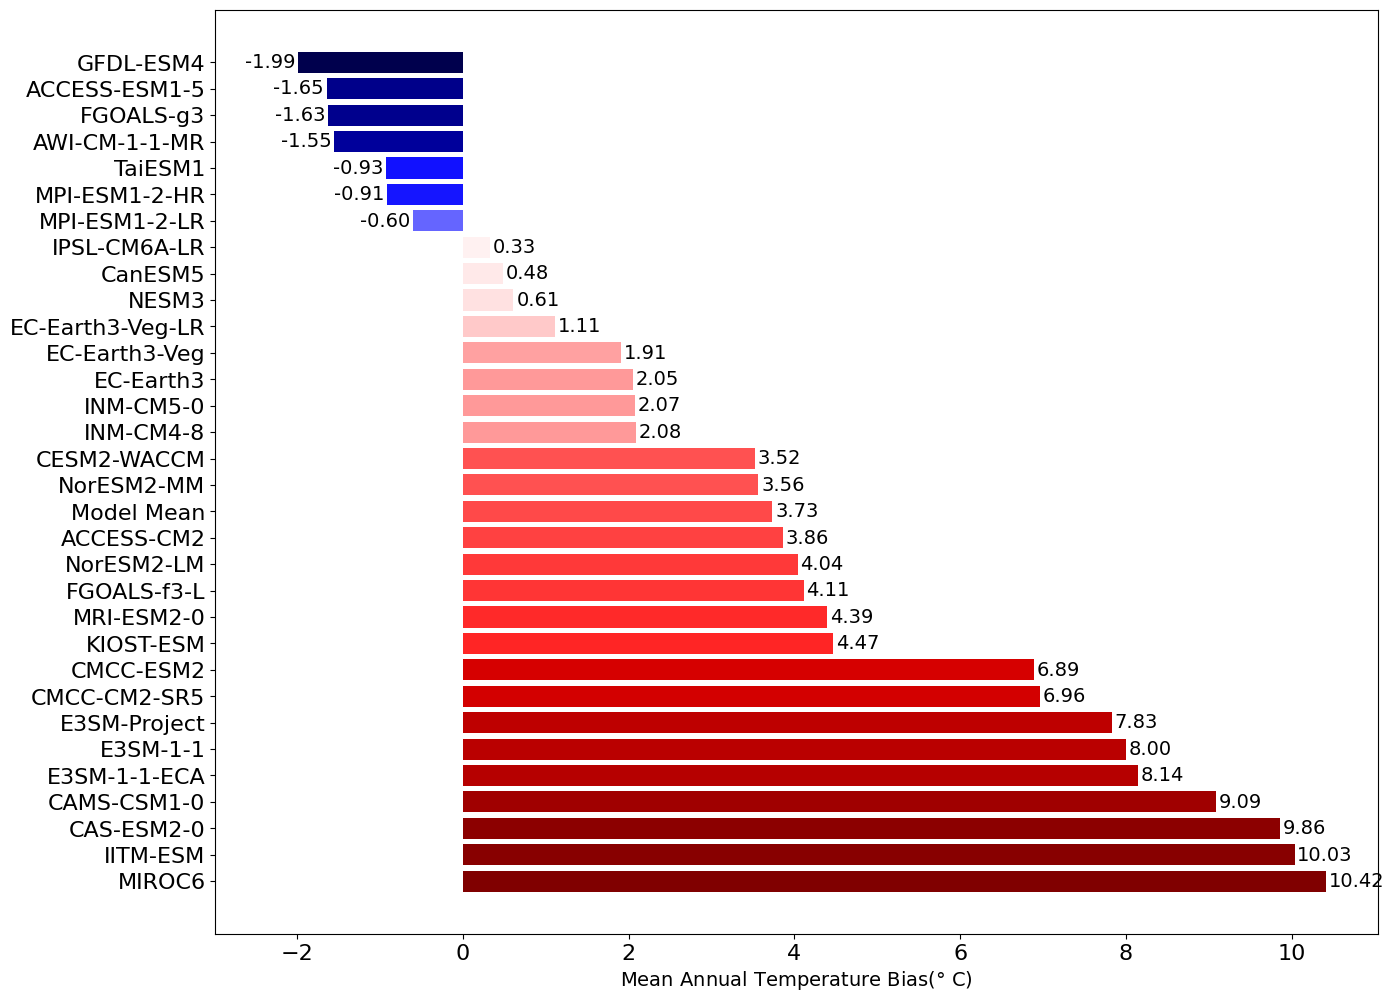

In [53]:
keys = list(('Ronne','Filchner'))

ronnefilch_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,weights_Ronne_Filchner,keys)

ronnefilch_yearly_fig, weights_ronnefilch_yearly_sortted = creating_model_bias_dict_and_plot(ronnefilch_applied_weights,keys,'Ronne')

{'LarsenB':          Model Names  Mean Bias
20        ACCESS-CM2  -0.025627
18     ACCESS-ESM1-5  -0.039180
9      AWI-CM-1-1-MR  -0.048595
4        CAMS-CSM1-0   0.034697
1         CAS-ESM2-0   0.055293
28       CESM2-WACCM   0.007278
11      CMCC-CM2-SR5   0.029179
12         CMCC-ESM2   0.025712
26           CanESM5  -0.008401
0           E3SM-1-1   0.050492
29      E3SM-1-1-ECA   0.053354
3       E3SM-Project   0.057845
14         EC-Earth3   0.059846
22     EC-Earth3-Veg   0.066443
23  EC-Earth3-Veg-LR   0.055833
8        FGOALS-f3-L   0.050409
17         FGOALS-g3  -0.054342
21         GFDL-ESM4   0.007274
15          IITM-ESM   0.127274
6          INM-CM4-8   0.058102
7          INM-CM5-0   0.041862
13      IPSL-CM6A-LR  -0.002971
2          KIOST-ESM   0.027751
27            MIROC6   0.074381
5      MPI-ESM1-2-HR  -0.033158
30     MPI-ESM1-2-LR   0.000162
25        MRI-ESM2-0  -0.017698
31        Model Mean   0.024006
24             NESM3   0.038348
19        NorESM2-LM   0.025

NameError: name 'f2' is not defined

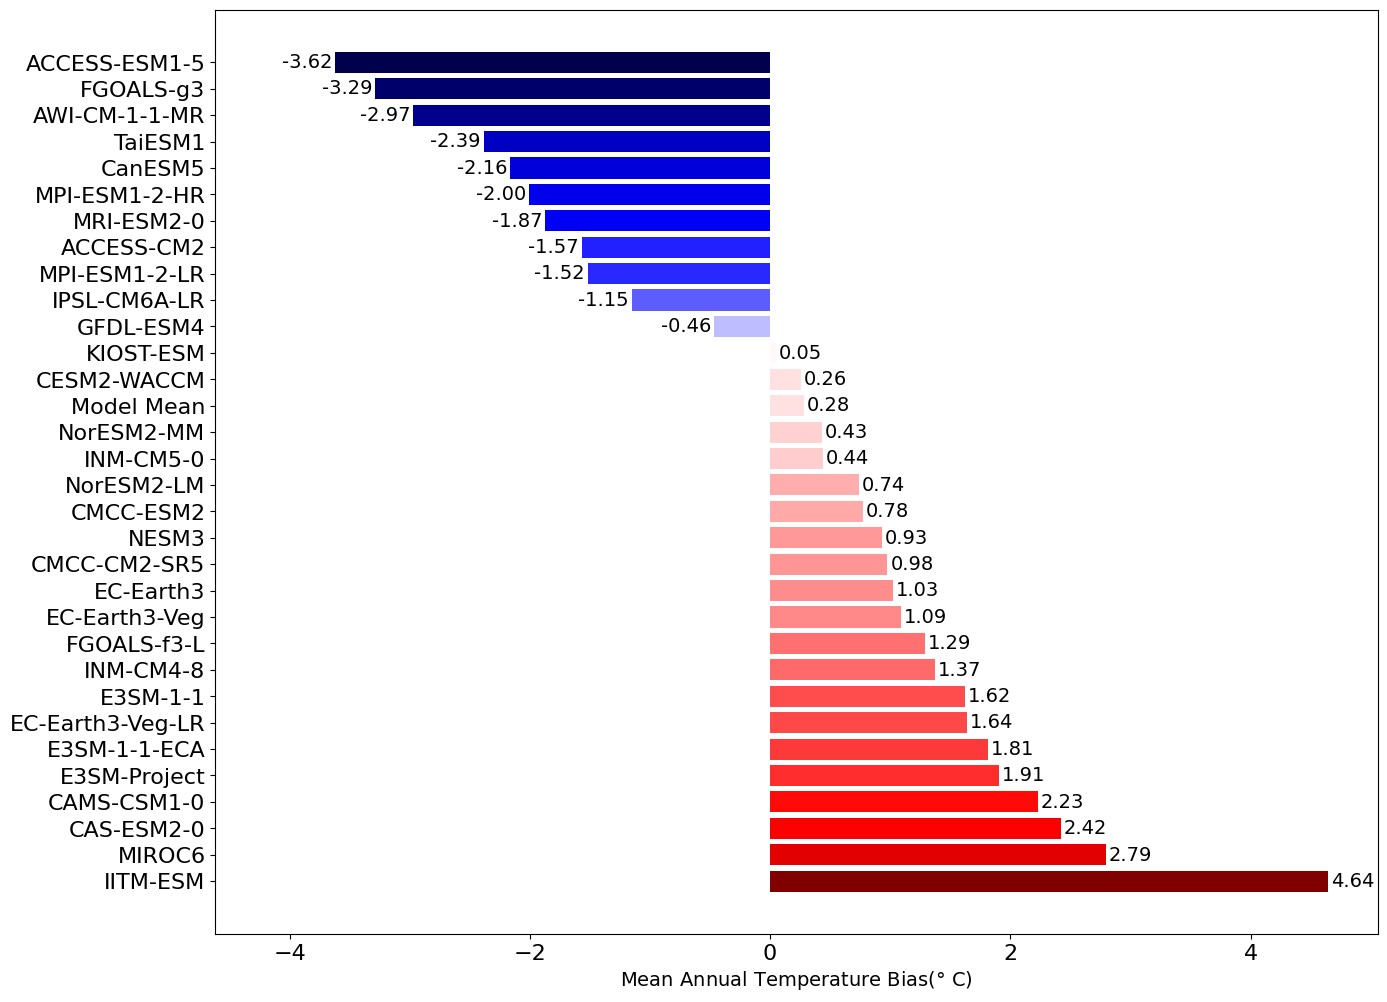

In [54]:
keys = list(('LarsenB','LarsenC','LarsenD'))

larsen_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,weights_Larsen,keys)

larsen_yearly_fig, weights_larsen_yearly_sortted = creating_model_bias_dict_and_plot(larsen_applied_weights,keys,'LarsenB')

{'Dotson':          Model Names  Mean Bias
20        ACCESS-CM2   0.703450
18     ACCESS-ESM1-5  -0.236017
9      AWI-CM-1-1-MR  -0.394138
4        CAMS-CSM1-0   1.391620
1         CAS-ESM2-0   1.520147
28       CESM2-WACCM   0.433242
11      CMCC-CM2-SR5   0.912590
12         CMCC-ESM2   0.936189
26           CanESM5   0.167246
0           E3SM-1-1   1.387217
29      E3SM-1-1-ECA   1.381810
3       E3SM-Project   1.392846
14         EC-Earth3   1.330103
22     EC-Earth3-Veg   1.345388
23  EC-Earth3-Veg-LR   1.561800
8        FGOALS-f3-L   1.078626
17         FGOALS-g3   0.042448
21         GFDL-ESM4   0.248076
15          IITM-ESM   2.123605
6          INM-CM4-8   0.799230
7          INM-CM5-0   0.758085
13      IPSL-CM6A-LR   0.606295
2          KIOST-ESM   0.923835
27            MIROC6   2.050655
5      MPI-ESM1-2-HR  -0.019425
30     MPI-ESM1-2-LR   0.207117
25        MRI-ESM2-0   0.344556
31        Model Mean   0.828734
24             NESM3   0.457945
19        NorESM2-LM   0.7759

NameError: name 'f2' is not defined

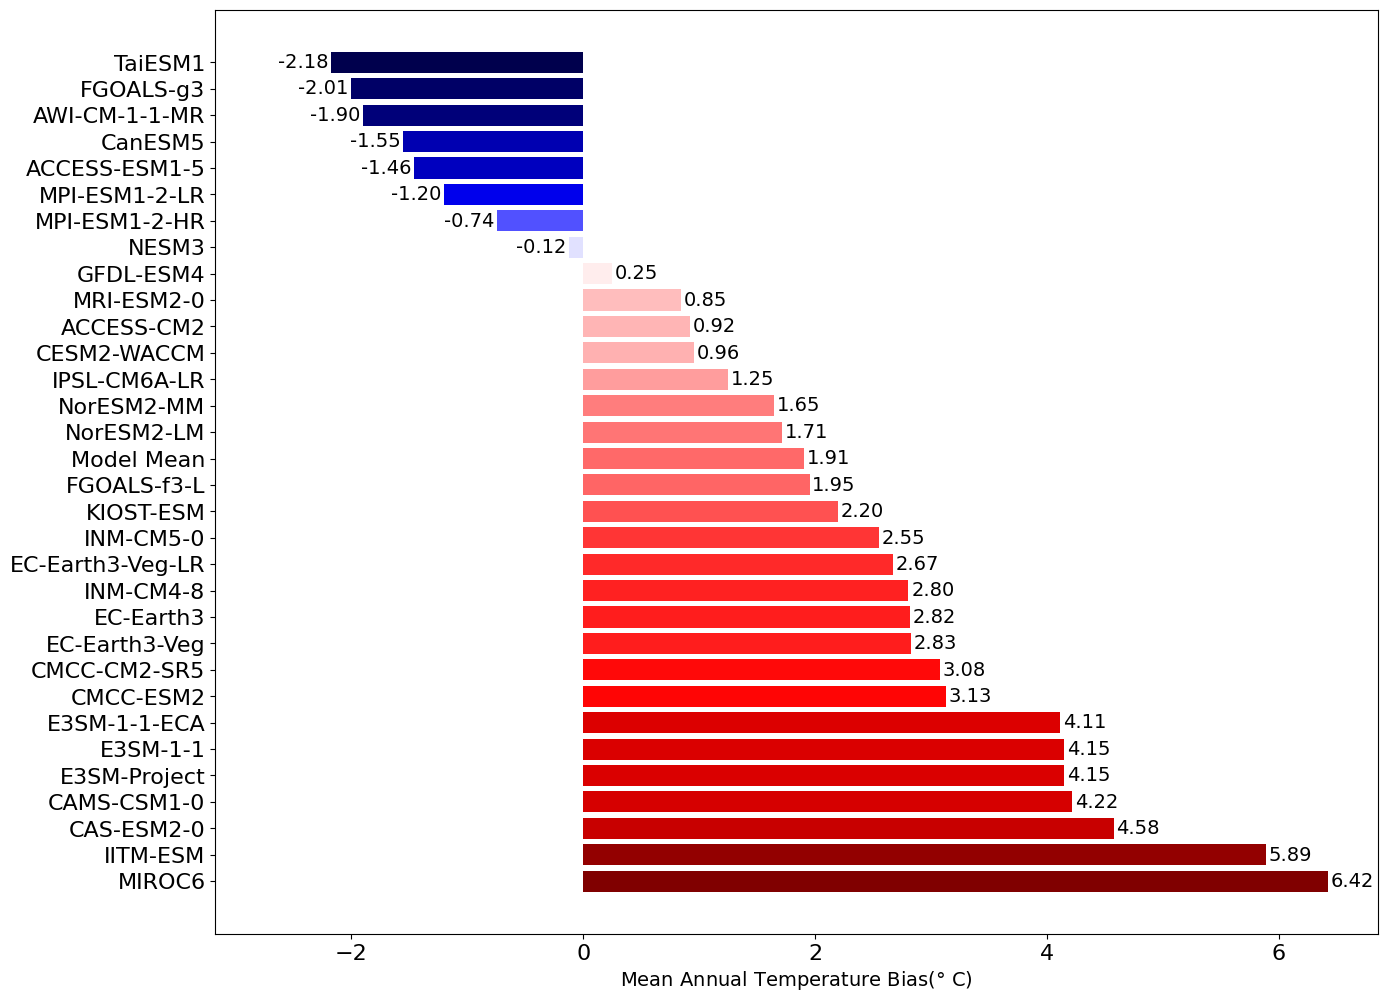

In [55]:
keys = list(('Dotson','Crosson','Thwaites','pine island'))

ASE_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,weights_ASE,keys)

ASE_yearly_fig, weights_ASE_yearly_sortted = creating_model_bias_dict_and_plot(ASE_applied_weights,keys,'Thwaites')

{'Abbot':          Model Names  Mean Bias
20        ACCESS-CM2   0.005484
18     ACCESS-ESM1-5  -0.006462
9      AWI-CM-1-1-MR  -0.020034
4        CAMS-CSM1-0   0.059057
1         CAS-ESM2-0   0.072931
28       CESM2-WACCM   0.008736
11      CMCC-CM2-SR5   0.026234
12         CMCC-ESM2   0.027334
26           CanESM5  -0.017762
0           E3SM-1-1   0.053288
29      E3SM-1-1-ECA   0.050790
3       E3SM-Project   0.052258
14         EC-Earth3   0.070462
22     EC-Earth3-Veg   0.074683
23  EC-Earth3-Veg-LR   0.067855
8        FGOALS-f3-L   0.018549
17         FGOALS-g3  -0.043678
21         GFDL-ESM4   0.001845
15          IITM-ESM   0.106477
6          INM-CM4-8   0.059988
7          INM-CM5-0   0.052326
13      IPSL-CM6A-LR   0.003198
2          KIOST-ESM   0.038832
27            MIROC6   0.087950
5      MPI-ESM1-2-HR  -0.002642
30     MPI-ESM1-2-LR   0.001086
25        MRI-ESM2-0   0.002020
31        Model Mean   0.029520
24             NESM3   0.012807
19        NorESM2-LM   0.02096

[ 2.09633732e-02 -6.15383428e-02  1.28280681e-03 -1.76104978e-04
 -2.20142370e-04 -8.89413889e-04 -2.66506966e-03  1.55744491e-03
  3.88682519e-03  8.60970855e-03 -2.68756152e-03  4.35506072e-03
  3.75054800e-01 -1.16151742e-02  5.78063906e-03 -3.36702322e-03
  2.39553285e-03  1.73269589e-04  7.17226635e-04  1.64205486e-02
  3.34169121e-03 -4.22300313e-04 -6.57260236e-03 -9.02576373e-04
 -4.10543014e-03 -2.78292419e-03  5.87904665e-03 -4.65184909e-03
  2.09084700e-03 -1.46235783e-03  6.76239878e-04 -2.74725967e-03
  4.00017242e-02  9.86449086e-01  1.84414281e-01  1.41977077e+00
 -1.60335911e-02  4.09067471e-03  3.04737516e-02  4.40592473e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-0.0038651915621046497
[ 2.09633732e-02 -6.15383428e-02  1.28280681e-03 -1.76104978e-04
 -2.20142370e-04 -8.89413889e-04 -2.66506966e-03  1.55744491e-03
  3.88682519e-03  8.60970855e-03 -2.68756152e-03  4.35506072e-03
  3.75054800e-01 -1.16151742e-02  5.78063906e-03 

NameError: name 'f2' is not defined

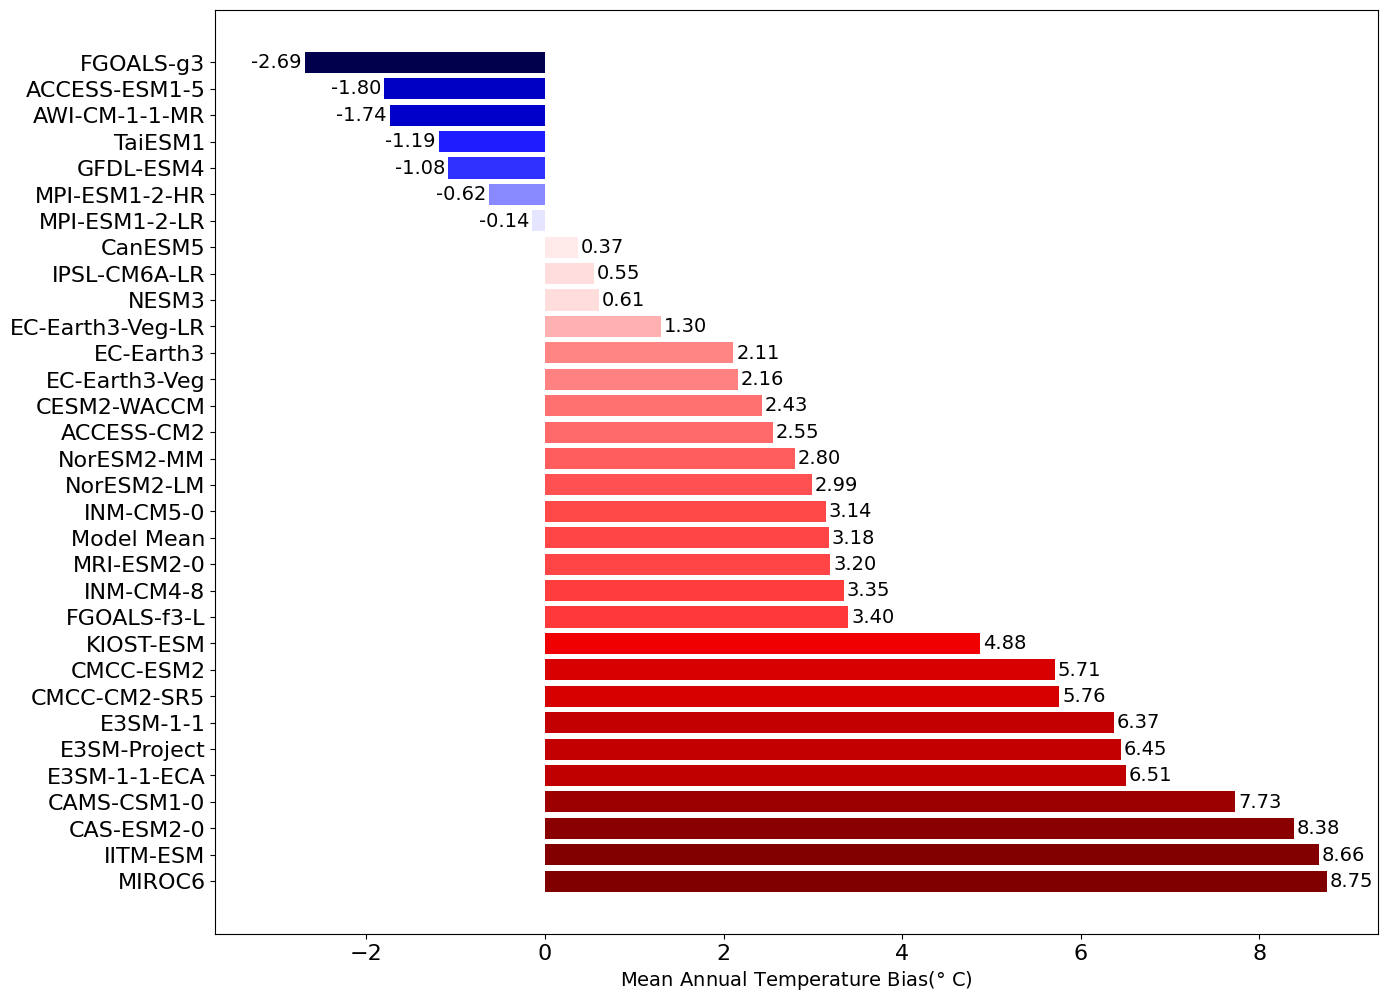

In [48]:
keys = bias_analysis_shelf_alphabet_seasonal.keys()

applied_weights_all_shelves_seasonal = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,total_shelf_weights,keys)

all_shelves_seasonal_fig, weights_all_shelves_seasonal_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_seasonal,keys,'Ross East')

### Yearly Bias Analysis

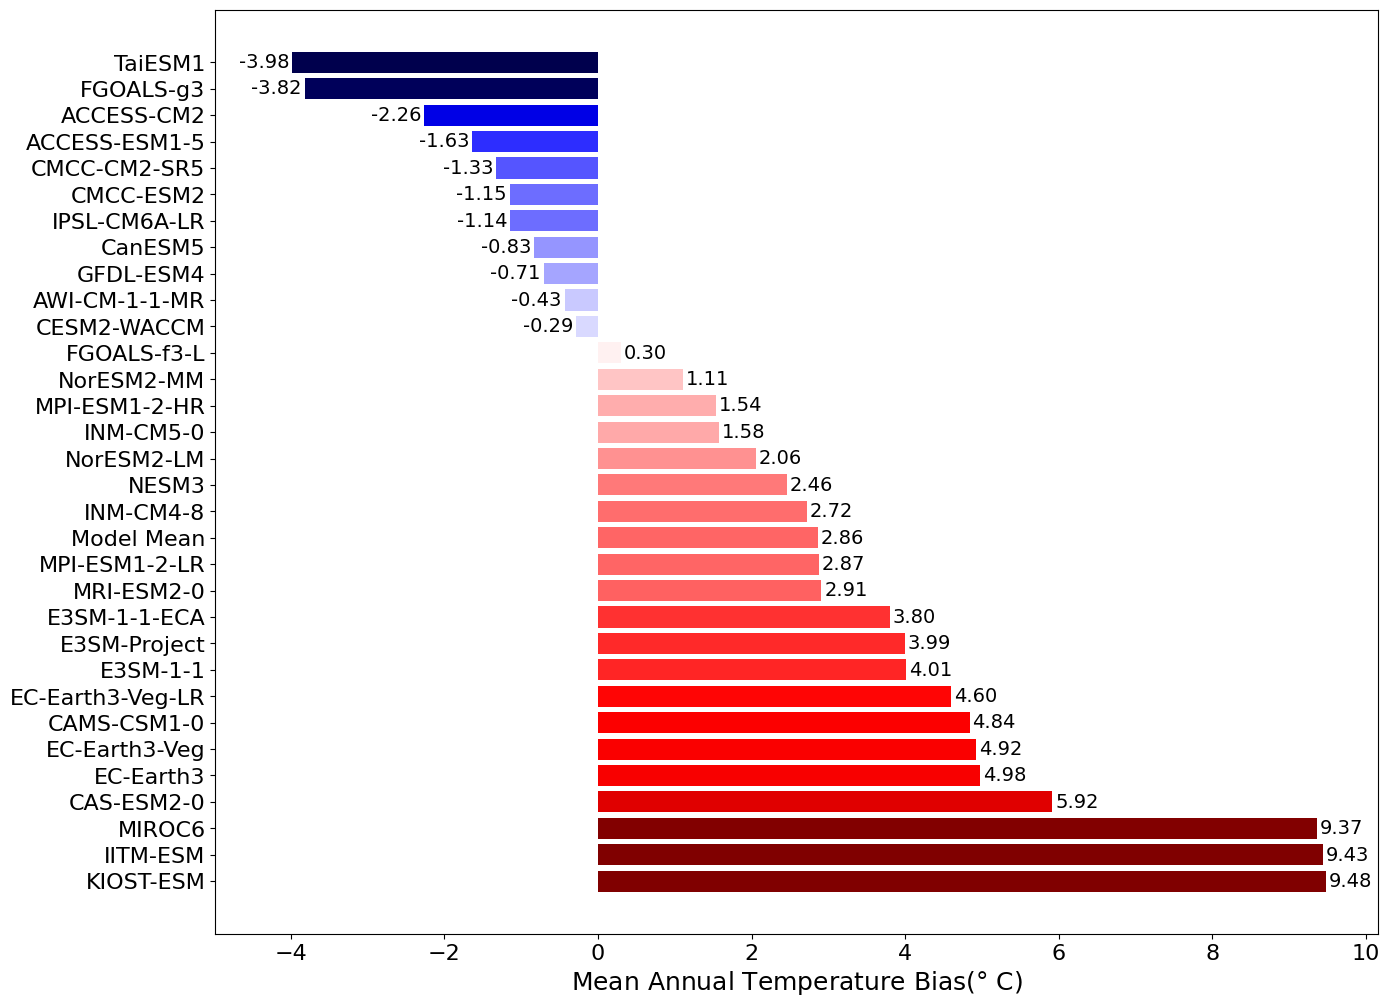

In [35]:
keys = list(('Ross East','Ross West'))

ross_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,weights_Ross,keys)

ross_yearly_fig, weights_ross_yearly_sortted = creating_model_bias_dict_and_plot(ross_applied_weights,'Ross East')

In [36]:
bias_analysis_shelf('Amery','yearly')

((<Figure size 1500x1200 with 1 Axes>,
  <AxesSubplot: xlabel='Mean Annual Temperature Bias($\\degree$ C)'>),
          Model Names  Mean Bias
 0           E3SM-1-1  -2.073267
 1         CAS-ESM2-0   6.139711
 2          KIOST-ESM   1.936641
 3       E3SM-Project  -1.985334
 4        CAMS-CSM1-0   7.009019
 5      MPI-ESM1-2-HR   3.765272
 6          INM-CM4-8  -5.896535
 7          INM-CM5-0  -6.108723
 8        FGOALS-f3-L   1.445924
 9      AWI-CM-1-1-MR  -1.866038
 10     MPI-ESM1-2-LR  -0.119243
 11           TaiESM1  -5.650776
 12      CMCC-CM2-SR5  -1.658620
 13         CMCC-ESM2  -1.812731
 14      IPSL-CM6A-LR  -3.189026
 15         EC-Earth3   3.793064
 16          IITM-ESM   6.909706
 17        NorESM2-MM  -0.524101
 18         FGOALS-g3  -4.448660
 19     ACCESS-ESM1-5  -2.732842
 20        NorESM2-LM  -4.869173
 21        ACCESS-CM2  -3.160612
 22         GFDL-ESM4  -0.450314
 23     EC-Earth3-Veg   4.022240
 24  EC-Earth3-Veg-LR   2.656917
 25             NESM3   1.303803

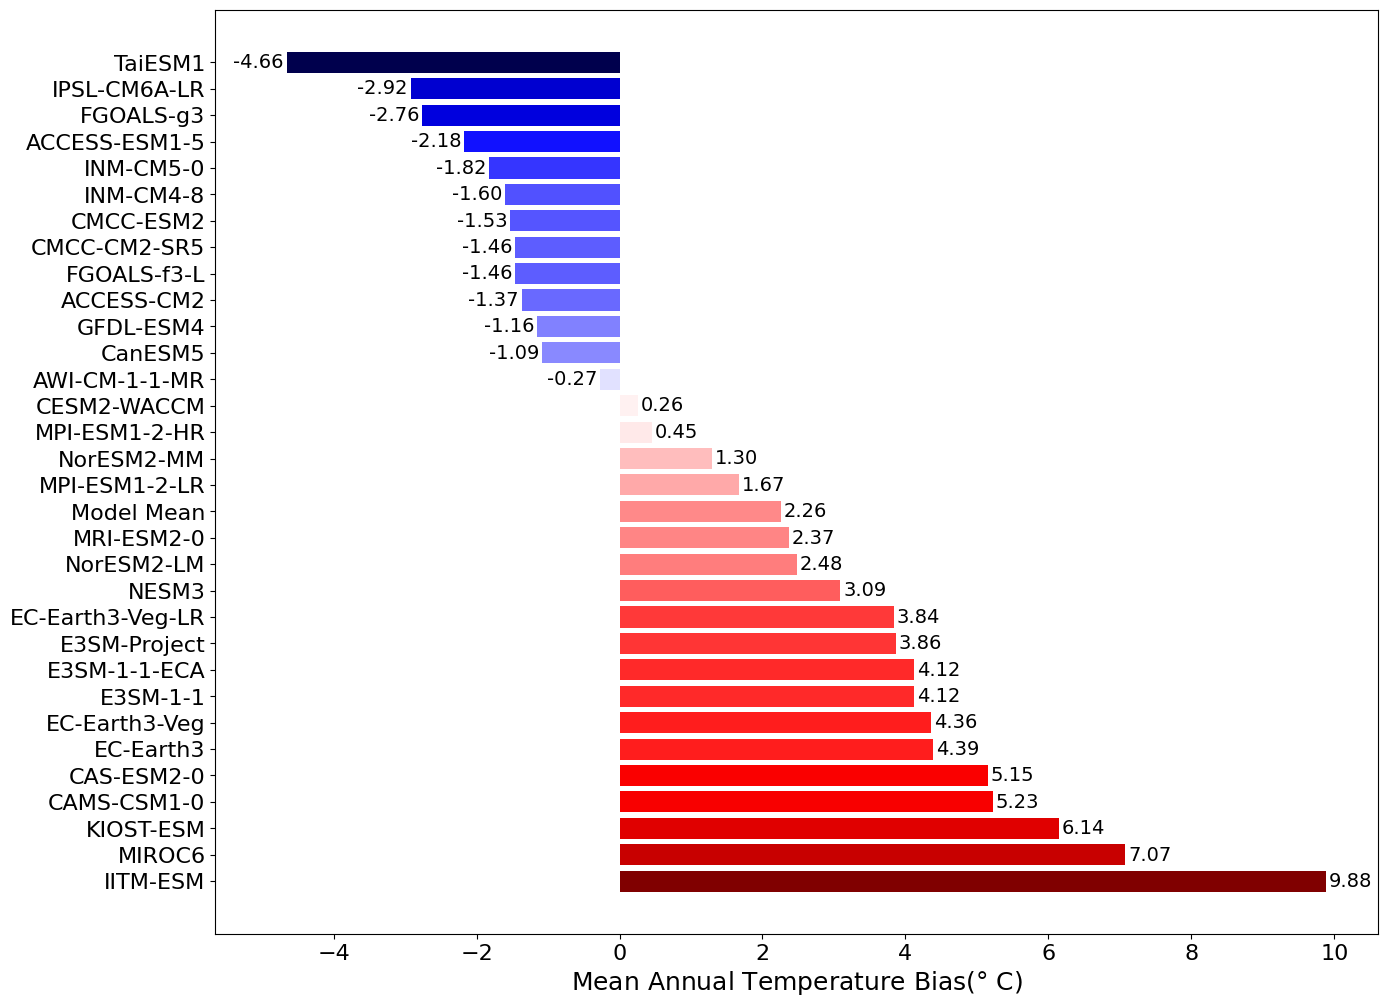

In [37]:
keys = list(('Ronne','Filchner'))

ronnefilch_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,weights_Ronne_Filchner,keys)

ronnefilch_yearly_fig, weights_ronnefilch_yearly_sortted = creating_model_bias_dict_and_plot(ronnefilch_applied_weights,'Ronne')

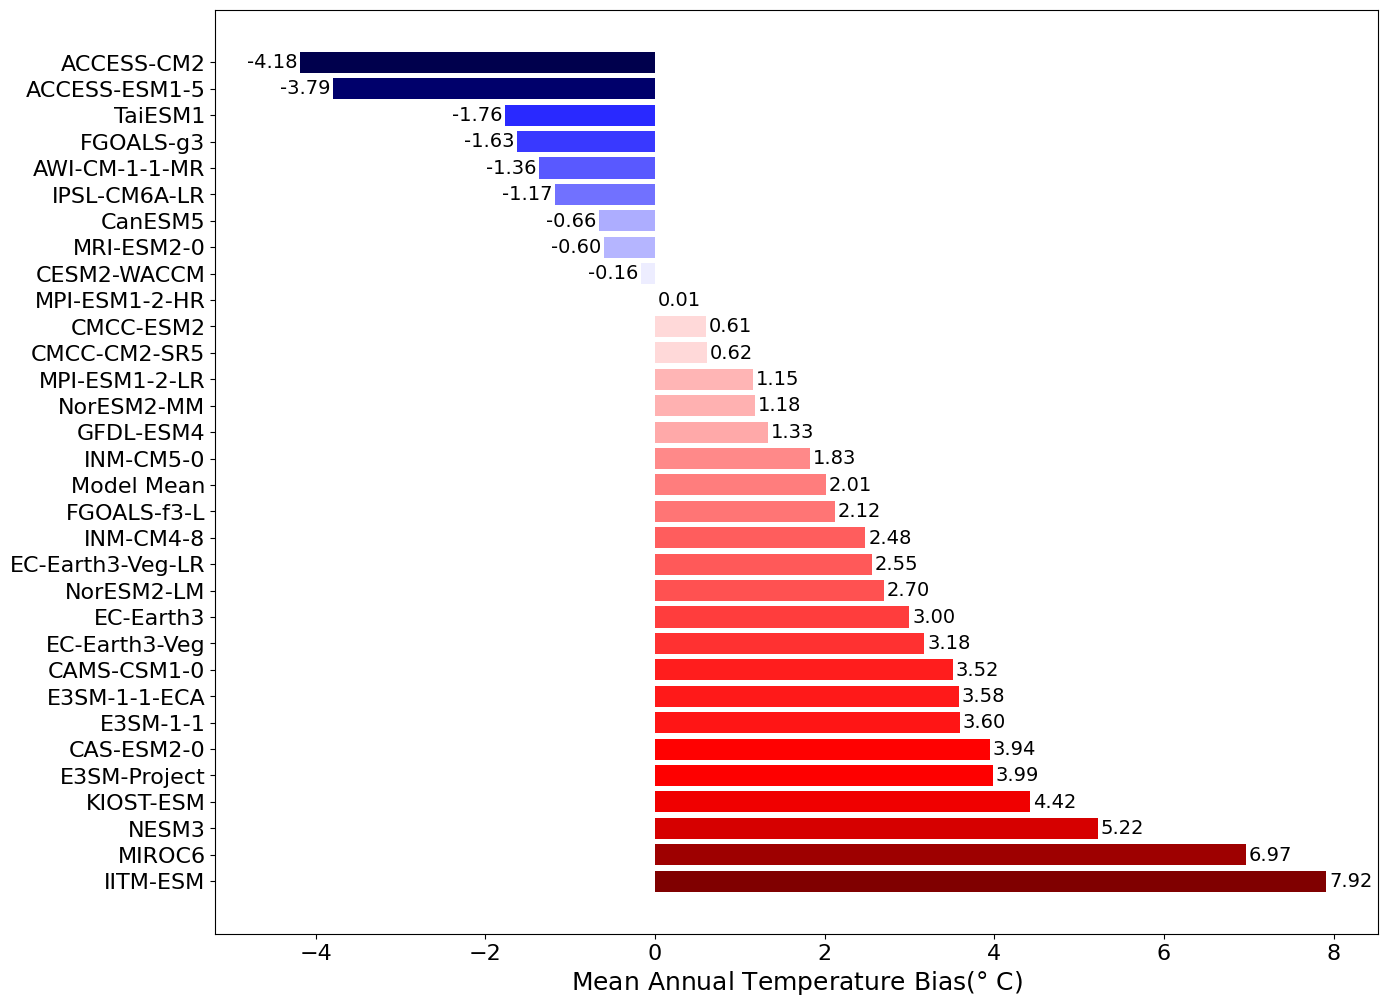

In [38]:
keys = list(('LarsenB','LarsenC','LarsenD'))

larsen_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,weights_Larsen,keys)

larsen_yearly_fig, weights_larsen_yearly_sortted = creating_model_bias_dict_and_plot(larsen_applied_weights,'LarsenB')

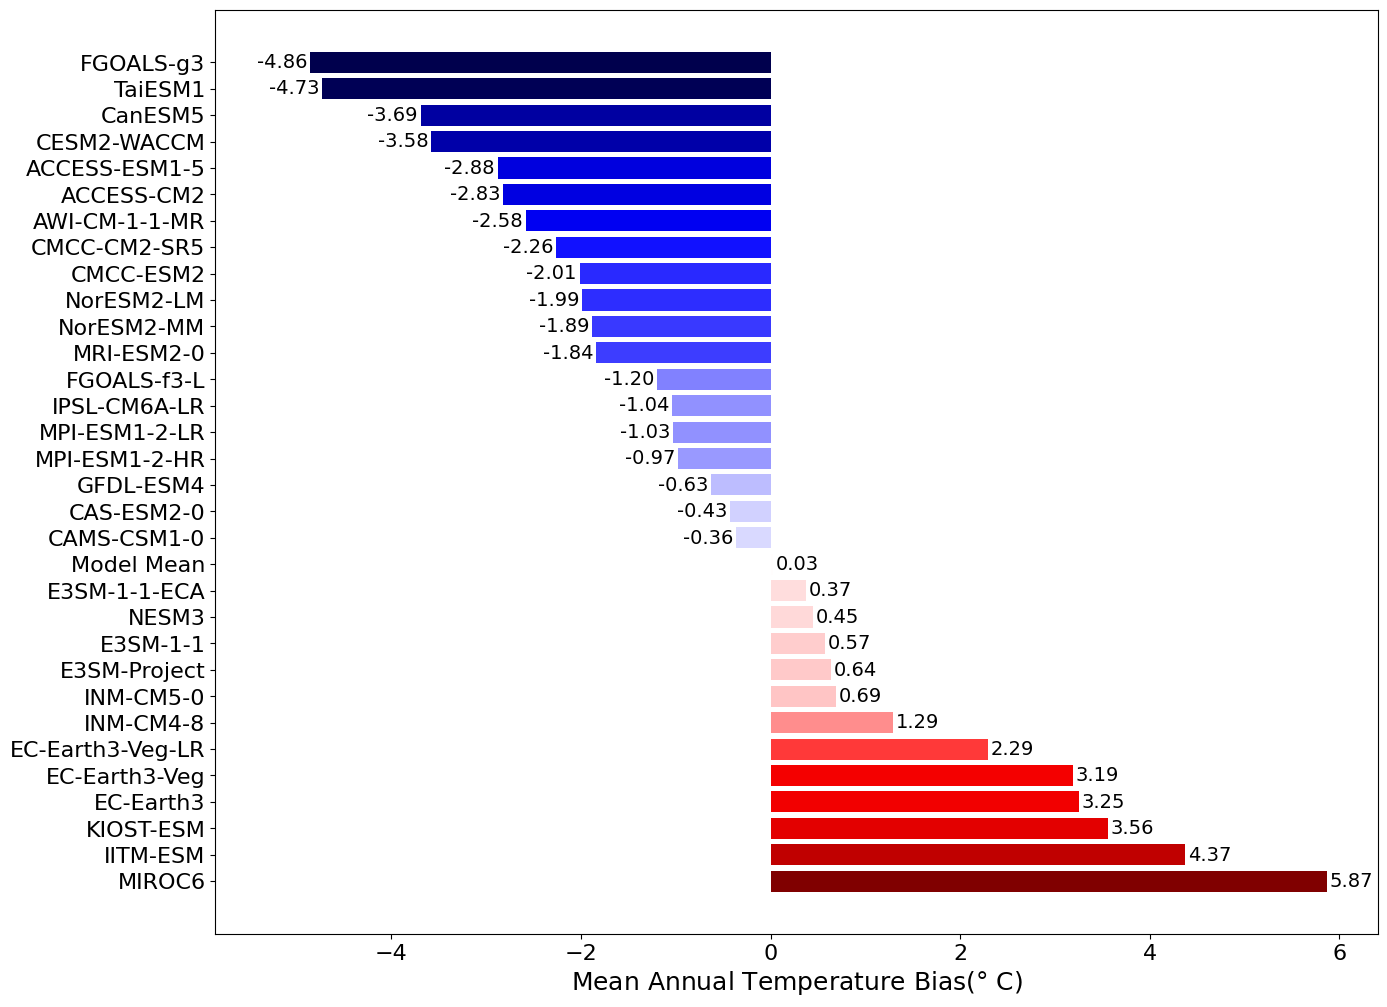

In [39]:
keys = list(('Dotson','Crosson','Thwaites','pine island'))

ASE_applied_weights = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,weights_ASE,keys)

ASE_yearly_fig, weights_ASE_yearly_sortted = creating_model_bias_dict_and_plot(ASE_applied_weights,'Thwaites')

{'Abbot':          Model Names  Mean Bias
20        ACCESS-CM2  -0.035550
18     ACCESS-ESM1-5  -0.016298
9      AWI-CM-1-1-MR  -0.029056
4        CAMS-CSM1-0   0.025465
1         CAS-ESM2-0   0.037550
28       CESM2-WACCM  -0.062407
11      CMCC-CM2-SR5  -0.046866
12         CMCC-ESM2  -0.041613
26           CanESM5  -0.054040
0           E3SM-1-1   0.016853
29      E3SM-1-1-ECA   0.012482
3       E3SM-Project   0.017610
14         EC-Earth3   0.042546
22     EC-Earth3-Veg   0.040986
23  EC-Earth3-Veg-LR   0.043873
8        FGOALS-f3-L  -0.019138
17         FGOALS-g3  -0.078940
21         GFDL-ESM4  -0.020056
15          IITM-ESM   0.094356
6          INM-CM4-8   0.045182
7          INM-CM5-0   0.037021
13      IPSL-CM6A-LR  -0.034072
2          KIOST-ESM   0.069556
27            MIROC6   0.099340
5      MPI-ESM1-2-HR  -0.001759
30     MPI-ESM1-2-LR   0.006557
25        MRI-ESM2-0  -0.030993
31        Model Mean   0.006602
24             NESM3   0.030373
19        NorESM2-LM  -0.02305

[-0.02305132  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
-0.12311895370211628
[-0.02305132 -0.12311895  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

NameError: name 'f2' is not defined

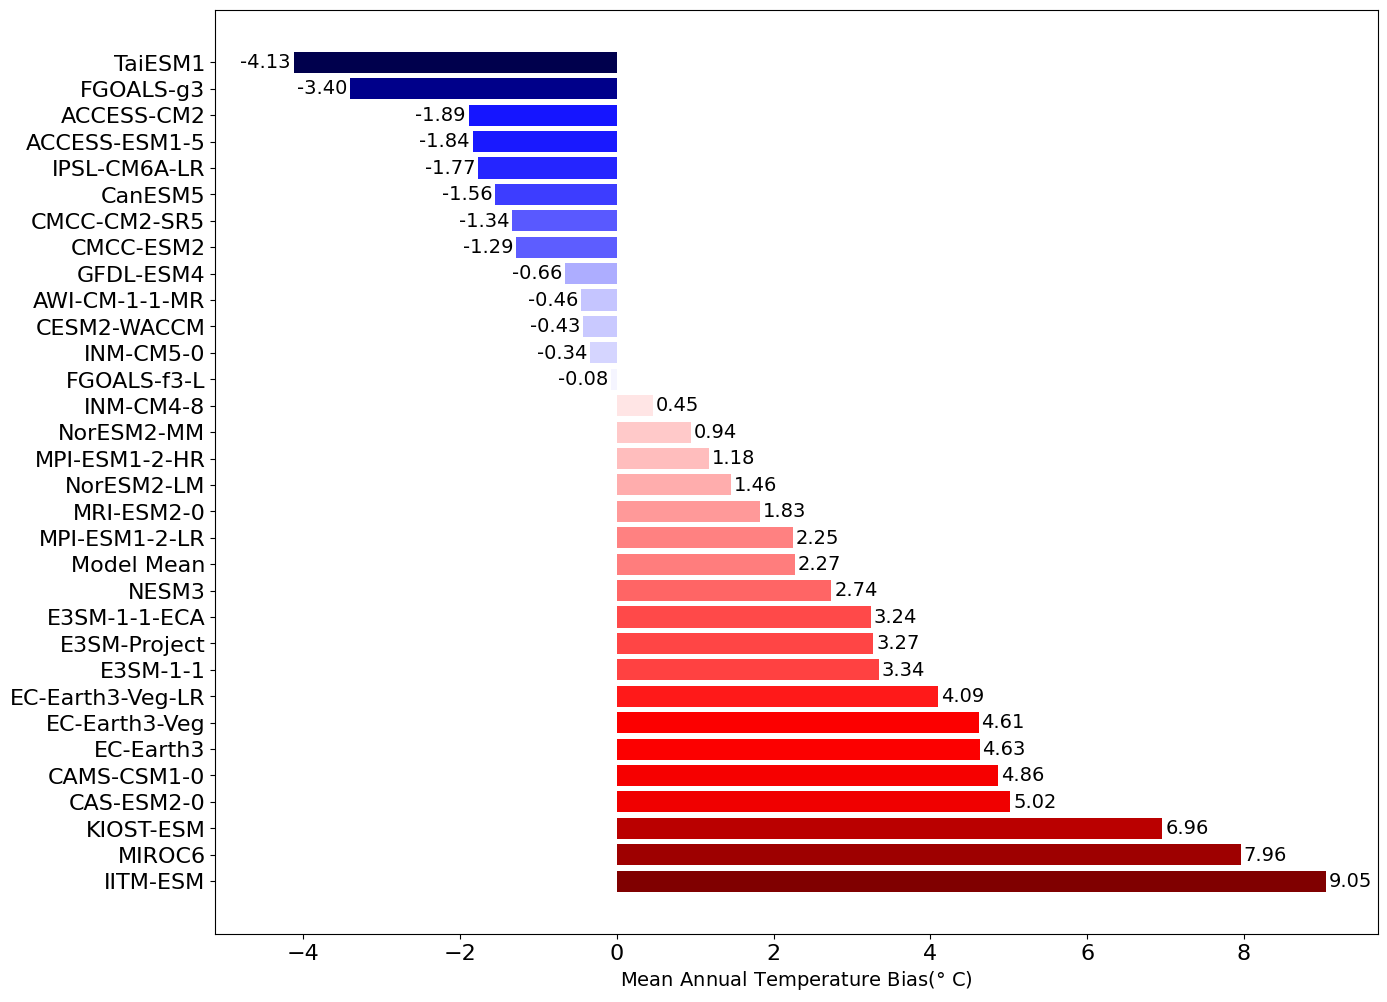

In [49]:
keys = bias_analysis_shelf_alphabet_yearly.keys()

applied_weights_all_shelves_yearly = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,total_shelf_weights,keys)

all_shelves_yearly_fig, weights_all_shelves_yearly_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_yearly,keys,'Ross East')

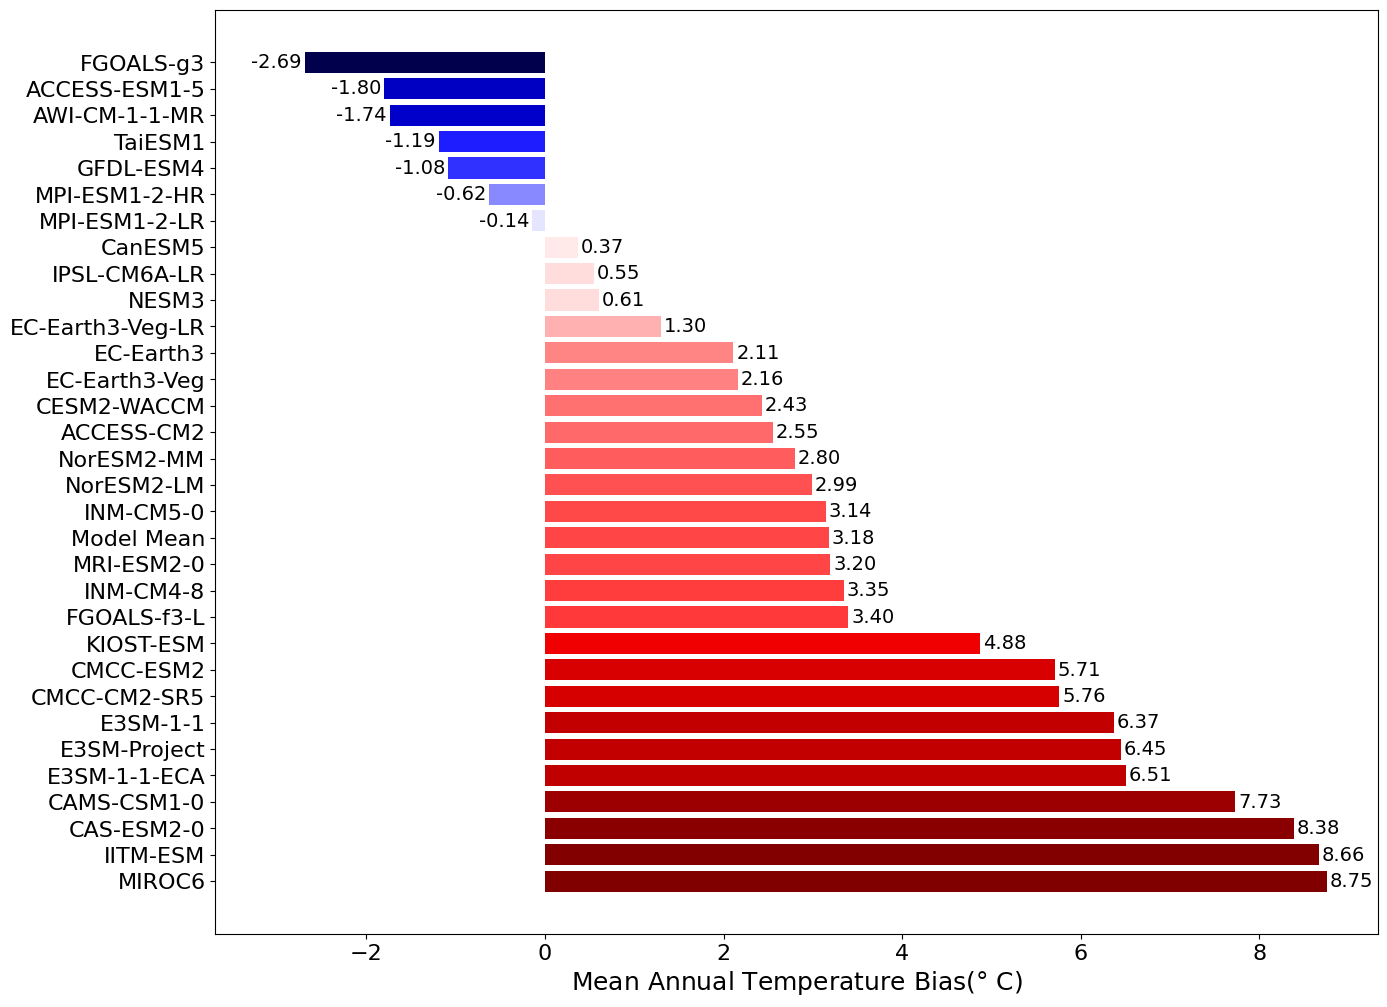

In [41]:

keys = bias_analysis_shelf_alphabet_seasonal.keys()
applied_weights_all_shelves_seasonal = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,total_shelf_weights,keys)
all_shelves_seasonal_fig, weights_all_shelves_seasonal_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_seasonal,'Ross East')


In [42]:
model_bias = list()
names = list()

for i in range(1):
    values = np.zeros(len(applied_weights_all_shelves_seasonal))
    model_name = bias_analysis_yearly['Ross East']['Model Names'][i]
    print(model_name)
    names.append(model_name)

    k = 0
    for key in applied_weights_all_shelves_seasonal:
        print(key)
        x = applied_weights_all_shelves_seasonal[key]['Mean Bias'][i]
        print(x)
        values[k] = x
        #weight = np.sum(values)
        k += 1
    
    print(values)
    weight = np.sum(values)
    print(weight)
    model_bias.append(weight)

df = pd.DataFrame(list(zip(names,model_bias)),columns=['Model Names','Weighted Mean Bias'])

E3SM-1-1
Abbot
0.05328750994757791
Amery
0.08428104544325317
Atka
0.0027382705778316277
Baudouin
0.03792708360399082
Borchgrevink
0.028664145328288048
Conger Glenzer
0.000809561330173146
Cook
0.0004398629356848042
Cosgrove
0.0045869983830299655
Crosson
0.0078085334719367495
Dotson
0.015392142649352375
Drygalski
0.0022149972047404085
Ekstrom
0.009933666516172987
Filchner
0.7081110257941792
George VI
0.0028198317203999256
Getz
0.054381552827379775
Holmes
0.0004356432919155975
Jelbart
0.014755445525056948
Land
0.0011021969323319317
LarsenB
0.0014006015448229472
LarsenC
0.0287779870801699
LarsenD
0.014892886575158594
Lazarev
0.010000932756582143
Mariner
-0.0008946600644931745
Mertz
0.005586453760026273
Moscow University
0.0024318037469175
Nansen
0.001278907523032655
Nickerson
0.013516726969194525
Nivl
0.004172865856665187
pine island
0.011490926361707142
Prince Harald
0.000562621565516353
Quar
0.003392282402751278
Rennick
0.0021860688007337105
Riiser-Larsen
0.10008131835610384
Ronne
1.9872